# Matter-Antimatter asymmetries at the LHC

## Example program

Author: Dr Marco Gersabeck

Copyright &copy; 2020-23 The University of Manchester

### Overview
This example code follows the structure described in the lab script and depicted in the scheme below.

<img src="LabScheme.png" width="600">

In [ ]:
!pip install ipynb

In [ ]:
!pip uninstall numpy -y
!pip install numpy==1.22.0

Found existing installation: numpy 1.22.0
Uninstalling numpy-1.22.0:
  Successfully uninstalled numpy-1.22.0
  Using cached numpy-1.22.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### Configuration
The cell below imports all required Python modules. If you need more and add them there, make sure to execute this cell again before executing the cell requiring the new module.

In [1]:
import uproot
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as colors
from scipy.optimize import curve_fit 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
from tqdm import tqdm
from src.invariant_mass import find_invariant_mass
from src.file_reading import read_file
from sklearn.cluster import KMeans

### Input data
This opens input data files and assigns them to variables.

### Select data and calculate derived quantities
The following cell reads the input data. This is where all derived quantities (such as transverse momentum) should be calculated and where selection criteria are applied (such as the z component of the momentum being positive).

### Visualise data
The cell below produces histograms of the data contained in the arrays that were filled in the cell above.

Plotting 1D histogram


NameError: name 'master_probpi' is not defined

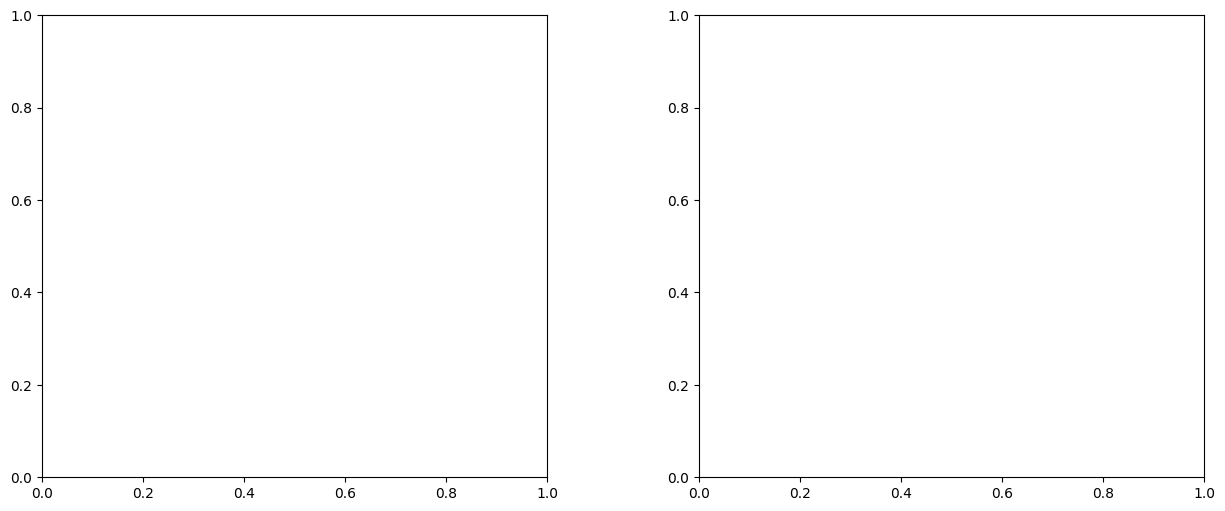

In [2]:
def plotting_histograms_probability(particle=None):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots
    print('Plotting 1D histogram')
    if particle == 1:
        interest_pi = h1_probpi
        interest_k  = h1_probk
    if particle == 2:
        interest_pi = h2_probpi
        interest_k  = h2_probk
    if particle == 3:
        interest_pi = h3_probpi
        interest_k = h3_probk
        
    else:
        interest_pi = master_probpi
        interest_k = master_probk
    values_probpi, bins_probpi, patches_probpi = ax[0].hist(interest_pi, bins=100, range=[0,1], histtype='step', 
                                                             label='$Prob_{particle} Pion$')
    ax[0].hist(interest_k, bins = 100, range = [0, 1],histtype='stepfilled',alpha=0.3,label='$p_{particle} kaon$')
    ax[0].set_xlabel('Probability')
    ax[0].set_ylabel('Entries')
    ax[0].legend()
    
    #plt.savefig(f"Prob Pion vs Kaon Histogram particle{particle}")
    #plt.savefig(f"Prob_kaon_pion_{particle}.pdf")
    
    print('Plotting 2D histogram')
    h2d = ax[1].hist2d(interest_pi, interest_k,
                       bins = [100,100], range = [[0,1],[0,1]],norm=colors.LogNorm())
    ax[1].set_xlabel(f'Probability Pion ')
    ax[1].set_ylabel(f'Probability Kaon ')
    fig.colorbar(h2d[3],ax=ax[1]) # let's add the colour scale
    #plt.savefig(f"Prob_pi_prob_k_{particle}_2d.pdf")
    return values_probpi, bins_probpi, patches_probpi

values_probpi, bins_probpi, patches_probpi = plotting_histograms_probability(particle=
                                                                            None)
    

Plotting 1D histogram


NameError: name 'h3_probpi' is not defined

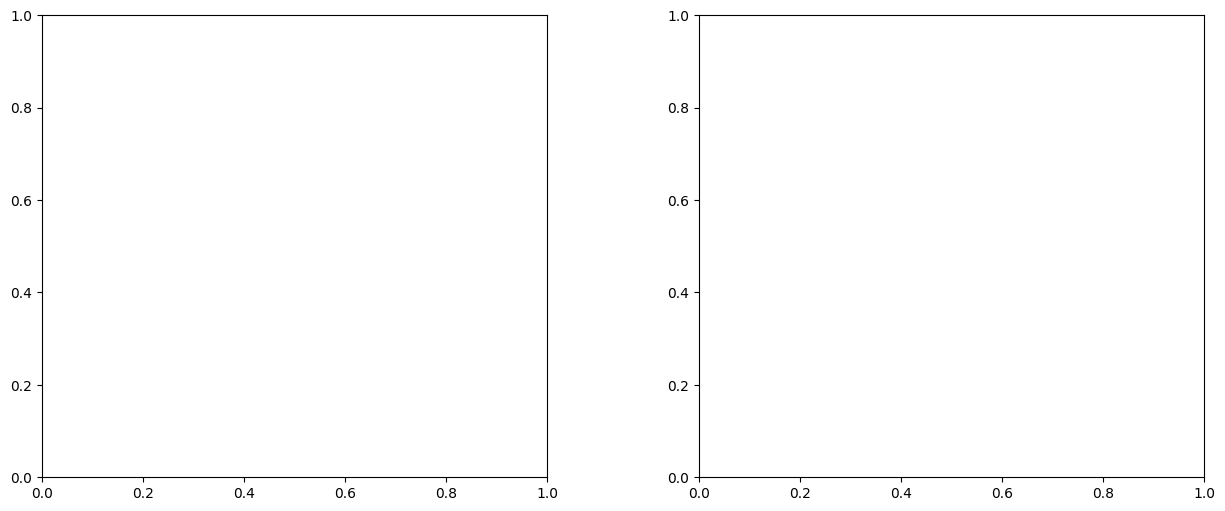

In [ ]:
plotting_histograms_probability(3)

## Clustering using SKLEARN

In [69]:

master_probpi = np.array(master_probpi).flatten()
master_probk  = np.array(master_probk).flatten()
master_probpi = np.expand_dims(master_probpi, axis=1)
master_probk  = np.expand_dims(master_probk, axis=1)
master_probability = np.concatenate((master_probpi, master_probk), axis=1)

# compute Pca on the master probability
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(master_probability)
pca.components_
pca.explained_variance_ratio_
pca.explained_variance_ratio_.sum()
pca.transform(master_probability)


NameError: name 'master_probpi' is not defined

In [ ]:
from sklearn.cluster import KMeans

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": [1,2,3,4,5,6],
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(master_probability)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': [1, 2, 3, 4, 5, 6]},
             scoring=<function gmm_bic_score at 0x7f9b72923b80>)

In [ ]:
import pandas as pd

df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

/home/codespace/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: >

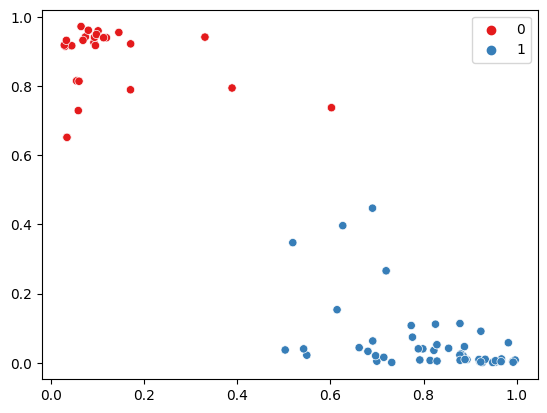

In [ ]:
# fit a kmeans clustering model to the data
kmeans = KMeans(n_clusters=2, random_state=0).fit(master_probability)
#plot the clusters

# SEABORN PLOT OF THE CLUSTERS
import seaborn as sns

# plot the clusters using seaborn 
sns.scatterplot(x=master_probability[:,0], y=master_probability[:,1], hue=kmeans.labels_, palette='Set1')

In [ ]:
#fit a GMM model to the data using EM algorithm#
gmm = GaussianMixture(n_components=2, covariance_type='tied').fit(master_probability)
#plot the clusters
sns.scatterplot(x=master_probability[:,0], y=master_probability[:,1], hue=gmm.predict(master_probability), palette='Set1')
#seaborn set labels
plt.xlabel('Probability Pion')
plt.ylabel('Probability Kaon')
plt.title('GMM Clustering of Pion and Kaon Probabilities')
#plt.scatter(master_probability[:,0], master_probability[:,1], c=gmm.predict(master_probability), cmap='rainbow')

In [ ]:
#get the probabilities of assignment of each point to each cluster
gmm_probs = gmm.predict_proba(master_probability)
#plot the probabilities of assignment of each point to each cluster
# sns.scatterplot(x=master_probability[:,0], y=master_probability[:,1], hue=gmm_probs[:,0], palette='Set1')
# #seaborn set labels
# plt.xlabel('Probability Pion')
# plt.ylabel('Probability Kaon')
# plt.title('GMM Clustering of Pion and Kaon Probabilities')


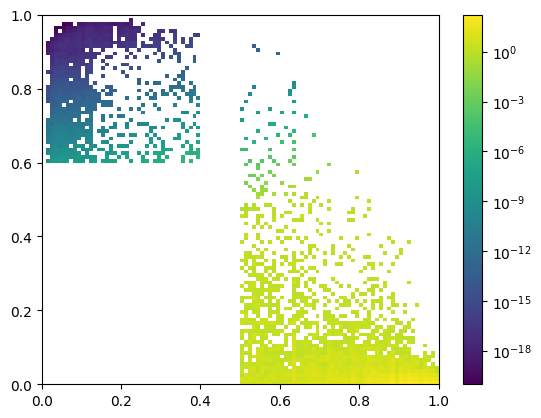

Bad pipe message: %s [b'\xd5\x1a\x8d\xdc\xd0.a\xeef\xdfW\\\xe3\xb1\xf0\xb6\x8a[ \x0c\x85\xed\xeeC\xf6\x17\xd4\xb7#k\x06\xdc\x12\xac\\Z\x05\xc6(\xbd\xe9t\xd0\xffW\xfbg\xd9\xcc\xf9\xc1\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05']
Bad pipe message: %s [b'\x04\x01\x05\x01\x06\x01\x00']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \xeb ]\xe6\xed\xd1=\x0f\x9d\xa13R\xd9\x96-\xf0\xf2\xb6]\xfe\xc8\xa4']
Bad pipe message: %s [b';\x8c\x003E\xde\x0c\xacw\xc5\xaa\x88J\xc1\xd4gs\xa0\x00\x00\xa2\xc0\x14\xc0\n\x009\x008\x007\x006\x00\x88\x00\x87\x00\x86\x00\x85\xc0\x19\x00:\x00\x89\xc0\x0f\xc0\x05\x005\x00\x84\xc0\x13\xc0\t\x003\x002\x001\x000\x00\x9a\x00\x99\x00\x98\x00\x

In [ ]:
np.shape(gmm_probs)
#tkae the differnece between the probabilities of assignment to each cluster
gmm_probs_diff = gmm_probs[:,0] - gmm_probs[:,1];
#gmm_abs = np.abs(gmm_probs_diff)
#plot using a 2d histogram
sns.color_palette("flare", as_cmap=True)

plt.hist2d(master_probability[:,0], master_probability[:,1], bins=100, range=[[0,1],[0,1]], weights=gmm_probs_diff, norm=colors.LogNorm())
plt.hist2d(master_probability[:,0], master_probability[:,1], bins=100, range=[[0,1],[0,1]], weights=gmm_probs[:,0],  norm=colors.LogNorm())
#add a colour bar
plt.colorbar()

#need to fix this, to essnetially show the difference in the probabilities of assignment to each cluster


#plt.hist(gmm_probs_diff, bins=100, range=[-1,1], histtype='step', label='GMM')

Plot the probability of being a pion versus the gmm assignment probability

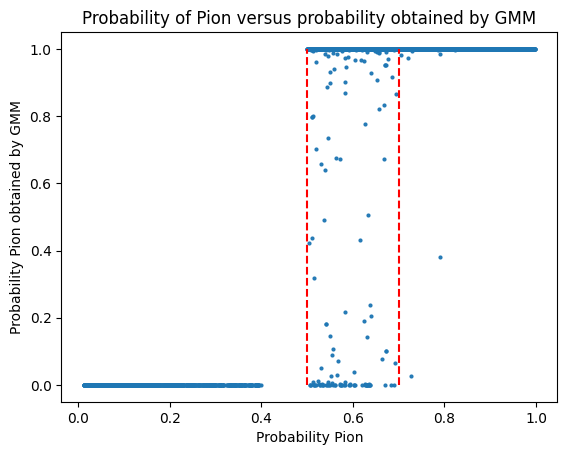

In [57]:
#plt.hist(gmm_probs[:,0], bins=100, range=[0,1], histtype='step', label='GMM')

plt.title("Probability of Pion versus probability obtained by GMM")
plt.plot(master_probability[:,0], gmm_probs[:,0], 'o', markersize=2, label='GMM', alpha=0.95, )
plt.xlabel('Probability Pion')
plt.ylabel('Probability Pion obtained by GMM')
#plot a line at 0.5

plt.plot([0.5,0.5], [0,1], color='red', linestyle='--')
plt.plot([0.7,0.7], [0,1], color='red', linestyle='--')


#plt.plot([0,1],[0,1], color='black', linestyle='--')
#scatter plot of the probabilities of assignment to each cluster



# plt.title("Probability of Kaon versus probability obtained by GMM")
# plt.plot(master_probability[:,1], gmm_probs[:,1], 'o', markersize=1, label='GMM')

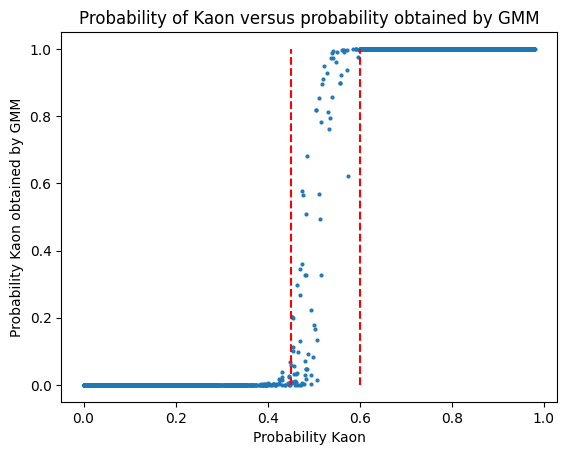

In [61]:
#plotting the same for Kaon
plt.title("Probability of Kaon versus probability obtained by GMM")
plt.plot(master_probability[:,1], gmm_probs[:,1], 'o', markersize=2, label='GMM', alpha=0.95, )
plt.xlabel('Probability Kaon')
plt.ylabel('Probability Kaon obtained by GMM')
#plot a line at 0.5

plt.plot([0.45,0.45], [0,1], color='red', linestyle='--')
plt.plot([0.6,0.6], [0,1], color='red', linestyle='--')

## Cleaning the resonsnaces

In [5]:
from src.clean_background import seperate_background_signal

background, signal = seperate_background_signal()

print("Background: ", background.shape)

AttributeError: 'NoneType' object has no attribute 'any'

## Finding Invariant Mass


Invariant Mass for a simulated dataset

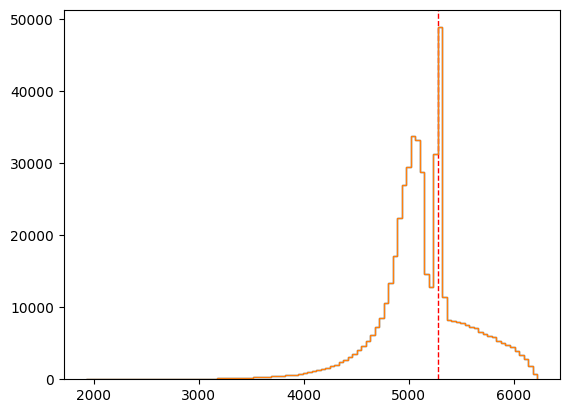

In [3]:
invariant_mass_numpy = np.genfromtxt('/workspaces/labs_yr3/matter_antimatter/data/inv_mass _second.csv', delimiter=',')
x_data = np.linspace(5100, 5600, 1000)

plt.hist(invariant_mass_numpy, bins=100,  histtype='step', label='Invariant Mass');
plt.axvline(5279, color='r', linestyle='dashed', linewidth=1);
values, bins, patches = plt.hist(invariant_mass_numpy, bins=100,  histtype='step', label='Invariant Mass');

### Fitting data

The following code shows how to fit a function to a dataset. The fit function is a sum of two functions, which can be extended to more complex functions. The output includes a chi2 calculation and plotting and saving of the resulting histogram.

In [4]:
BIN_NUM = 100

def get_bins(bins, values):
    #get the bin values
    bin_values = np.histogram(values, bins=bins, )
    #get the bin edges
    bin_edges = np.histogram_bin_edges(values, bins=bins)
    #get the bin centres
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2
    return  bin_centres
def get_bins_values(mode="B+", BINS=100, x_min=5100, x_max=5800, data_generation = 1):

    if mode == "B+":
        #dataset = np.genfromtxt('/workspaces/labs_yr3/matter_antimatter/data/inv_mass_positive_two.csv', delimiter=',')
        dataset = np.genfromtxt('/workspaces/labs_yr3/matter_antimatter/data/filtered_by_type/inv_mass_filtered_all_Bminus.csv', delimiter=',')
    elif mode == "B-":
        dataset = np.genfromtxt('/workspaces/labs_yr3/matter_antimatter/data/filtered_by_type/inv_mass_filtered_all_Bplus.csv', delimiter=',')

    else:
        if data_generation == 1:

            dataset = np.genfromtxt('/workspaces/labs_yr3/data/inv_mass.csv', delimiter=',')
        else:
            dataset = np.genfromtxt('/workspaces/labs_yr3/matter_antimatter/data/inv_mass _second.csv', delimiter=',')
    #x_data = np.linspace(x_min, x_max, BINS)
    invariant_mass_numpy = np.array(dataset)
    invariant_mass_numpy = np.where((
        invariant_mass_numpy > x_min) & (
        invariant_mass_numpy < x_max), invariant_mass_numpy, np.nan)
    values, bins, patches = plt.hist(invariant_mass_numpy, bins=BIN_NUM);
    plt.close()
    return bins, values, patches, invariant_mass_numpy

def clean_data(y_data, y_other):

    for y_indivual in y_other:
        y_data = y_data - y_indivual
    
    return y_data

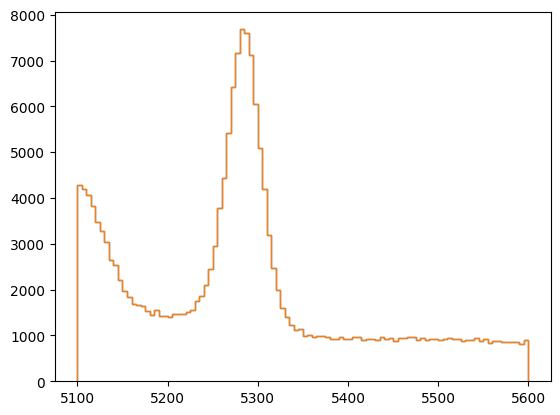

In [5]:
invariant_mass_numpy = np.where((
        invariant_mass_numpy > 5100) & (
        invariant_mass_numpy < 5600), invariant_mass_numpy, np.nan)
plt.hist(invariant_mass_numpy, bins=100,  histtype='step', label='Invariant Mass');
values, bins, patches = plt.hist(invariant_mass_numpy, bins=100,  histtype='step', label='Invariant Mass');


In [22]:
import scipy.special
#fit a gaussian to the dataset 
def gaussian(x, norm, mean, sigma):
    return np.array( (1 / sigma) * norm * np.exp( -0.5 * ( (x-mean)/sigma )**2 ) )
def exponential(x, norm, decay, xoffset):
# this is a technical parameter, which can be used to move the position at which the function evaluates to "norm"
    return np.array( (1 / decay )  * norm * np.exp(-(x-xoffset)/decay) )


def constant(x, norm):
    return np.array( norm * np.ones(len(x)) )

def half_gaussian(x, norm, mean, sigma):
    return np.array( (1 / sigma) * norm * np.exp( -0.5 * ( (x-mean)/sigma )**2 ) * (x > mean) )

# implement the Crystal Ball function
def crystal_ball(x, mean, sigma, alpha, n, normalisation):

    A = (n/abs(alpha))**n * np.exp(-alpha**2/2)
    B = n/abs(alpha) - abs(alpha)
    C = (n/abs(alpha)) * (1/(n-1)) * np.exp(-alpha**2/2)
    D = np.sqrt(np.pi/2) * (1 + scipy.special.erf(abs(alpha)/np.sqrt(2)))
    N = 1 / (sigma * (C + D))
    N = normalisation * N
    #N = normalisation 
    seperater_val = (x - mean) / sigma
    data = np.array([N * np.exp(-0.5 * (seperater_val)**2) if seperater_val > -alpha else N * A * (B - seperater_val)**(-n) for seperater_val in seperater_val])
    return data


In [6]:
#plot the exponential between 5100 and 5600
x_data = np.linspace(5600, 6000, 1000)
plt.plot(x_data, exponential(x_data, 1e9, 100, 5100), label='Exponential')

NameError: name 'exponential' is not defined

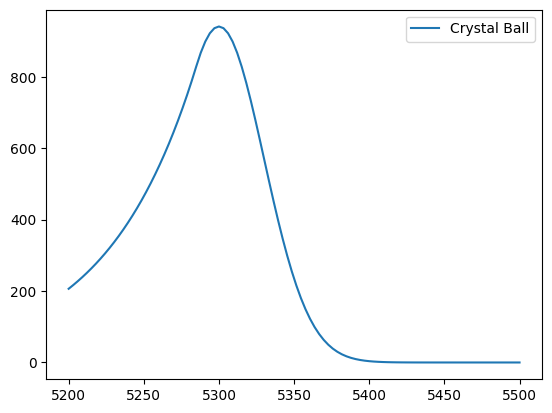

In [9]:
plt.plot(np.linspace(5200, 5500, 100), crystal_ball(np.linspace(5200, 5500, 100), 5300, 30, 0.5, 40, 100000), label='Crystal Ball')
plt.legend()

In [19]:
def fit_func(x, norm, mean, sigma):
    return np.array( gaussian(x, norm, mean, sigma) )
def fit_func_triple(x, norm1, mean1, sigma1, norm2, mean2, sigma2, normE, decayE):
    return np.array(gaussian(x, norm1, mean1, sigma1) + gaussian(x, norm2, mean2, sigma2)  + exponential(x, normE, decayE))

def fit_func_quad(x, norm1, mean1, sigma1, norm2, mean2, sigma2, normE, decayE, constant):
    return np.array(gaussian(x, norm1, mean1, sigma1) + gaussian(x, norm2, mean2, sigma2) + exponential(x, normE, decayE) + constant(x, constant))

def fit_func_trip_gauss(x, norm1, mean1, sigma1, norm2, mean2, sigma2, norm3, mean3, sigma3):
    return np.array(gaussian(x, norm1, mean1, sigma1) + gaussian(x, norm2, mean2, sigma2) + gaussian(x, norm3, mean3, sigma3))

def fit_func_half(x, norm1, mean1, sigma1, norm2, mean2, sigma2, normE, decayE,
                  offsetE):
    return np.array(half_gaussian(x, norm1, mean1, sigma1) +
                    gaussian(x, norm2, mean2, sigma2) +
                    exponential(x, normE, decayE, offsetE))

def fit_crystal(x, norm1, mean1, sigma1,  mean, sigma, alpha, norm, n, normE, decayE, offsetE):
    return np.array(gaussian(x, norm1, mean1, sigma1) + crystal_ball(x, mean, sigma, alpha, n, norm) + exponential(x, normE, decayE, offsetE))



In [11]:
# popt, pcov = curve_fit(fit_func_triple, get_bins(bins, values), values, 
#                         p0 = [1000, 4100, 5, 1000, 5400, 40, 10, 5 ])

# popt_triple, pcov_triple = curve_fit(fit_func_trip_gauss, get_bins(bins, values), values,
#                             p0 = [1000, 4100, 5, 1000, 5200, 10,1000, 5800, 100
#                                  ])

# y_data = fit_func_trip_gauss(x_data, popt_triple[0], popt_triple[1], popt_triple[2],
#                          popt_triple[3], popt_triple[4], popt_triple[5], popt_triple[6],
#                          popt_triple[7], popt_triple[8])

popt, pcov = curve_fit(fit_func_half, get_bins(bins, values), values,
                        p0 = [1000, 5100, 5, 1000, 5300, 10, 10, 5, 5100 ],
                        maxfev=1000000)
print(popt)

y_data = fit_func_half(x_data, popt[0], popt[1], popt[2],
                        popt[3], popt[4], popt[5],
                        popt[6], popt[7], popt[8])

[ 5.08253333e+14  3.15439242e+03  3.08511413e+02  1.29684320e+05
  5.28403468e+03  1.99520796e+01 -5.73189361e+11 -1.39957521e+11
 -7.60141922e+11]


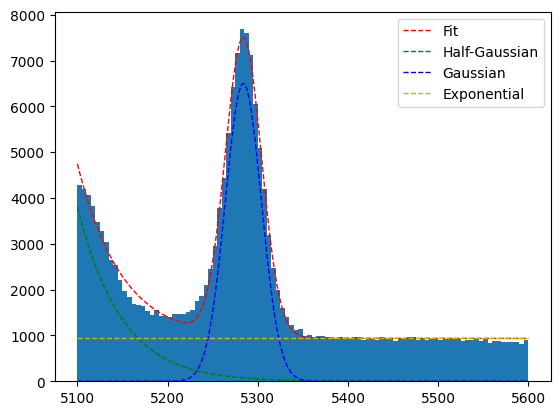

In [12]:
y_plot_1 = half_gaussian(x_data, popt[0], popt[1], popt[2])
y_plot_2 = gaussian(x_data, popt[3], popt[4], popt[5])
y_plot_3 = exponential(x_data, popt[6], popt[7], popt[8])

norm_area_counts = popt[3]


plt.hist(invariant_mass_numpy, bins=BIN_NUM)
plt.plot(x_data, y_data, color='r', linestyle='dashed', linewidth=1, label='Fit')
plt.plot(x_data, y_plot_1, color='g', linestyle='dashed', linewidth=1, label='Half-Gaussian')
plt.plot(x_data, y_plot_2, color='b', linestyle='dashed', linewidth=1, label='Gaussian')
plt.plot(x_data, y_plot_3, color='y', linestyle='dashed', linewidth=1, label='Exponential')
plt.legend()

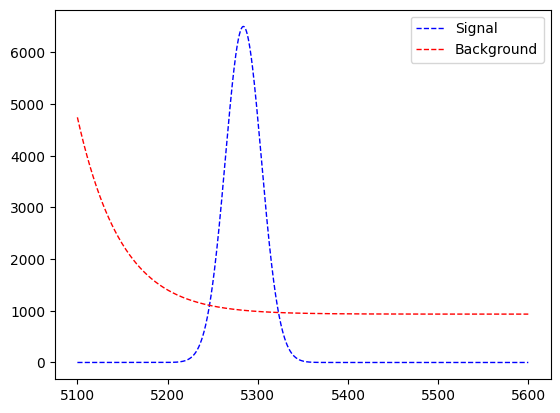

In [42]:
plt.plot(x_data, y_plot_2, color='b', linestyle='dashed', linewidth=1, label='Signal')
plt.plot(x_data, y_data-y_plot_2, color='r', linestyle='dashed', linewidth=1, label='Background')
plt.legend()


In [ ]:
#find the number of bins / mev
bin_width = (np.nanmax(invariant_mass_numpy) - np.nanmin(invariant_mass_numpy)) / BIN_NUM
bin_width
#find the max of invariant mass numpy that is a number
#find the number of counts in the signal region
signal_counts = bin_width * norm_area_counts
signal_counts

648469.5350208147

In [ ]:
invariant_mass_numpy

array([          nan, 5307.75060793,           nan, ..., 5552.81363764,
                 nan, 5467.46376985])

In [ ]:
#numerically integrate the signal using the x_data 
#and the y_data from the fit
signal_integral = np.trapz(y_data, x_data)


In [77]:
signal = y_plot_2
background = y_data - signal
def clean_data(y_data, y_other):

    for y_indivual in y_other:
        y_data = y_data - y_indivual
    
    return y_data

def significance_calc(signal, background, x_data_subsection):
    # find the area under the signal curve
    signal_integral = np.trapz(signal, x_data_subsection)
    background_integral = np.trapz(background, x_data_subsection)
    return signal_integral / np.sqrt(background_integral + signal_integral)


def optimise_significance(x_data, signal, background, x_min, x_max, p0=[5200, 5300]):
    
    #find the first index of the x_min that is greater than the x_min value

    x_min_index = np.argmax(x_data > x_min)
    x_max_index = np.argmin(x_data < x_max)
    x_data_subsection = x_data[x_min_index:x_max_index]
    signal_subsection = signal[x_min_index:x_max_index]
    background_subsection = background[x_min_index:x_max_index]
    #calculate the significance
    significance_val = significance_calc(signal_subsection, background_subsection, x_data_subsection)
    return significance_val

# find the maximum significance for the different x_min and x_max values

x_min = 5200
x_max = 5600

#optimise the significance for the different x_min and x_max values
best_significance = 0
iterations =  500

x_min_array = []
x_max_array = []

for i in range(iterations):

    curr_xmin = x_min + i

    for j in range(iterations):
        curr_xmax = x_max - j
        if curr_xmax < curr_xmin:
            break
        significance_new = optimise_significance(
            x_data, signal, background, curr_xmin, curr_xmax)
        
        if significance_new > best_significance:
            best_significance = significance_new

            x_min_opt = curr_xmin
            x_max_opt = curr_xmax

print("Optimal x_min: ", x_min_opt)
print("Optimal x_max: ", x_max_opt)
print("Optimal significance: ", best_significance)


/tmp/ipykernel_22513/4084436457.py:14: RuntimeWarning: invalid value encountered in double_scalars
  return signal_integral / np.sqrt(background_integral + signal_integral)


NameError: name 'x_min_opt' is not defined

456


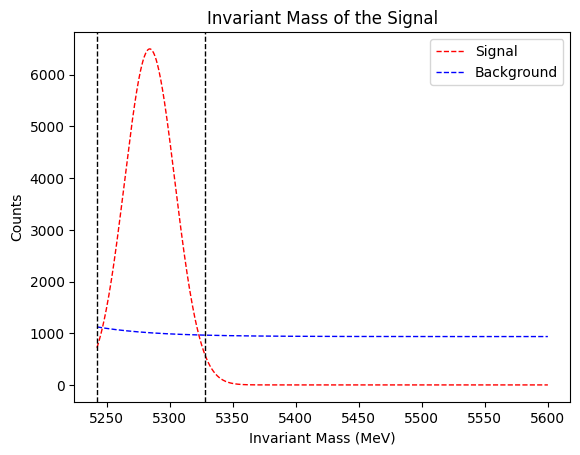

In [16]:
arg_min = np.argmax(x_data > x_min_opt)
arg_max = print(np.argmin(x_data < x_max_opt))
plt.plot(x_data[arg_min:arg_max], signal[arg_min:arg_max], color='r',
          linestyle='dashed', linewidth=1, label='Signal')
plt.plot(x_data[arg_min:arg_max], background[arg_min:arg_max], color='b',
            linestyle='dashed', linewidth=1, label='Background')
plt.xlabel('Invariant Mass (MeV)')
plt.ylabel('Counts')
plt.title('Invariant Mass of the Signal')
#vertical lines to show the x_min and x_max values

plt.axvline(x=x_min_opt, color='k', linestyle='dashed', linewidth=1)
plt.axvline(x=x_max_opt, color='k', linestyle='dashed', linewidth=1)
plt.legend()

## B+/B- Decay


In [130]:

    

# general_bins, general_values, general_patches, general_array = get_bins_values(mode="general", BINS=BIN_NUM, x_min=5100, x_max=5800, 
#                                                                               data_generation=2)        
positive_bins, positive_values, positive_patches, positive_array = get_bins_values(mode="B+", BINS=BIN_NUM, x_min=5100, x_max=5800)
negative_bins, negative_values, negative_patches, negative_array = get_bins_values(mode="B-", BINS=BIN_NUM, x_min=5100, x_max=5800)

# popt, pcov = curve_fit(fit_func, get_bins(general_bins, general_values),
#  general_array, p0 = [1000, 5100, 5, 1000, 5200, 10, 10, 5, 5100 ],
#     maxfev=10000)
popt_pve, pcov_pve = curve_fit(fit_func_half, get_bins(positive_bins, positive_values),
                                positive_values, p0 = [ 2000, 5100, 10,
                                                        1000, 5300, 10,
                                                         1e9, 100, 5100],
                                                        maxfev=1000000)
print(popt_pve)

popt_nve , pcov_nve = curve_fit(fit_func_half, get_bins(negative_bins, negative_values), negative_values,
                        p0 = [1000, 5100, 5, 1000, 5200, 10, 10, 5, 5100 ],
                        maxfev=100000)

y_data_pve = fit_func_half(x_data, popt_pve[0], popt_pve[1], popt_pve[2],
                        popt_pve[3], popt_pve[4], popt_pve[5],
                        popt_pve[6], popt_pve[7], popt_pve[8])
y_data_nve = fit_func_half(x_data, popt_nve[0], popt_nve[1], popt_nve[2],
                        popt_nve[3], popt_nve[4], popt_nve[5],
                        popt_nve[6], popt_nve[7], popt_nve[8])

                        

positive_bin_width = (np.nanmax(positive_bins) - np.nanmin(positive_bins)) / BIN_NUM
positve_norm_count = popt_pve[3]

negative_bin_width = (np.nanmax(negative_bins) - np.nanmin(negative_bins)) / BIN_NUM
negative_norm_count = popt_nve[3]
positive_signal_count = positive_bin_width * positve_norm_count
negative_signal_count = negative_bin_width * negative_norm_count




[ 9.17315290e+04  5.31940529e+03  3.18706113e+02  6.92695075e+04
  5.21337161e+03  1.29931654e+02  1.56435207e+12  1.00026598e+02
 -1.51335119e+05]


In [131]:
popt_pve, popt_nve

(array([ 9.17315290e+04,  5.31940529e+03,  3.18706113e+02,  6.92695075e+04,
         5.21337161e+03,  1.29931654e+02,  1.56435207e+12,  1.00026598e+02,
        -1.51335119e+05]),
 array([ 3.45053280e+05,  5.10252094e+03,  3.11228665e+02,  5.89492244e+05,
         4.99822105e+03,  4.96738587e+01,  6.45849996e+05,  5.23688957e+05,
        -4.46565706e+05]))

In [132]:
#discard last value of positve bins 
assymetry_calc = (positive_signal_count - negative_signal_count) / (positive_signal_count + negative_signal_count)
unc_assymetry = np.sqrt( 1- assymetry_calc ** 2) / np.sqrt(positive_signal_count + negative_signal_count)
print(f"The assymetry is given by {assymetry_calc:.5f} +/- {unc_assymetry:.5f}")


The assymetry is given by -0.78969 +/- 0.00034


In [133]:
binned_fititng_pve = fit_func_half(positive_bins[:-1], popt_pve[0], popt_pve[1], popt_pve[2],
                                   popt_pve[3], popt_pve[4], popt_pve[5],
                                   popt_pve[6], popt_pve[7], popt_pve[8])
binned_fititng_nve = fit_func_half(negative_bins[:-1], popt_nve[0], popt_nve[1], popt_nve[2],
                                      popt_nve[3], popt_nve[4], popt_nve[5],                                                
                                        popt_nve[6], popt_nve[7], popt_nve[8])

print(np.shape(binned_fititng_nve))
binned_fititng_nve
residual_pve = positive_values - binned_fititng_pve
residual_nve = negative_values - binned_fititng_nve

(100,)


Text(0.5, 1.0, 'Invariant Mass of B+')

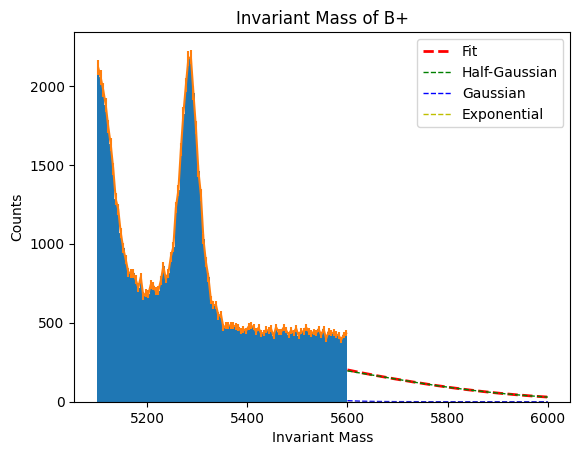

In [134]:
y_plot_1_pve = half_gaussian(x_data, popt_pve[0], popt_pve[1], popt_pve[2])
y_plot_2_pve = gaussian(x_data, popt_pve[3], popt_pve[4], popt_pve[5])
y_plot_3_pve = exponential(x_data, popt_pve[6], popt_pve[7], popt_pve[8])

plt.hist(positive_array, bins=BIN_NUM)
# add errors to the histogram 
# get number of counts in each bin
bin_width = (np.nanmax(positive_array) - np.nanmin(positive_array)) / BIN_NUM
def bin_contents(patches):
    bin_contents = []
    for i in range(len(patches)):
        bin_contents.append(patches[i].get_height() * 1 )
    return bin_contents
positive_bin_content = bin_contents(positive_patches)
plt.errorbar(get_bins(positive_bins, positive_values), positive_values, yerr=np.sqrt(positive_bin_content))

plt.plot(x_data, y_data_pve, color='r', linestyle='dashed', linewidth=2, label='Fit')
plt.plot(x_data, y_plot_1_pve, color='g', linestyle='dashed', linewidth=1, label='Half-Gaussian')
plt.plot(x_data, y_plot_2_pve, color='b', linestyle='dashed', linewidth=1, label='Gaussian')
plt.plot(x_data, y_plot_3_pve, color='y', linestyle='dashed', linewidth=1, label='Exponential')
#plt.plot(x_data, exponential(x_data, 500000000000, 1, 1), color='k', linestyle='dashed', linewidth=1, label='Exponential')
plt.legend()


plt.xlabel("Invariant Mass")
plt.ylabel("Counts")
plt.title("Invariant Mass of B+")

Text(0.5, 1.0, 'Residuals of B+')

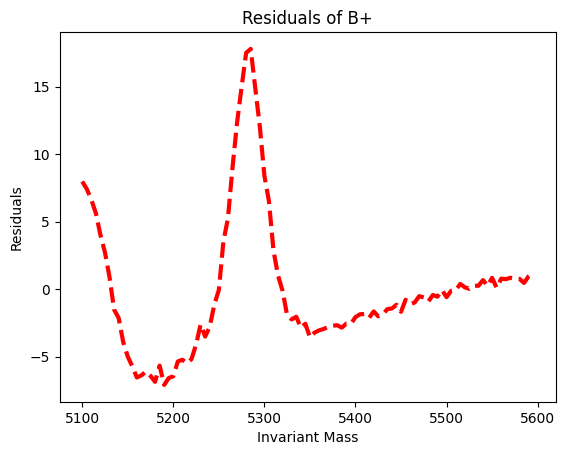

In [39]:
#plot the residuals
plt.figure()
#using the bin centeres calculate the residuals

plt.plot(positive_bins[:-1], residual_pve/ np.sqrt(positive_bins[:-1]), color='r', linestyle='dashed', linewidth=3, label='Residuals')
plt.xlabel("Invariant Mass")
plt.ylabel("Residuals")
plt.title("Residuals of B+")


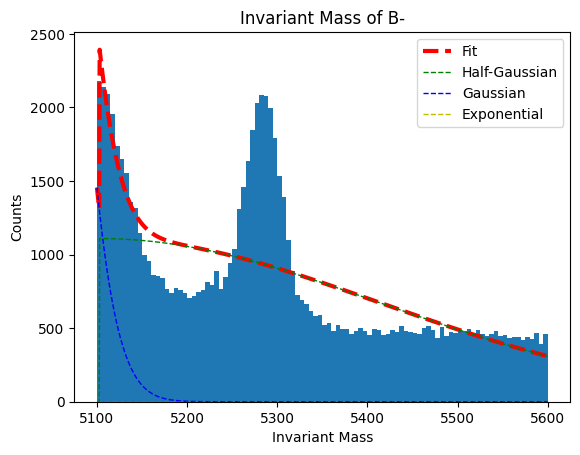

In [29]:


y_plot_1_nve = half_gaussian(x_data, popt_nve[0], popt_nve[1], popt_nve[2])
y_plot_2_nve = gaussian(x_data, popt_nve[3], popt_nve[4], popt_nve[5])
y_plot_3_nve = exponential(x_data, popt_nve[6], popt_nve[7], popt_nve[8])

plt.hist(negative_array, bins=BIN_NUM)
plt.plot(x_data, y_data_nve, color='r', linestyle='dashed', linewidth=3, label='Fit')
plt.plot(x_data, y_plot_1_nve, color='g', linestyle='dashed', linewidth=1, label='Half-Gaussian')
plt.plot(x_data, y_plot_2_nve, color='b', linestyle='dashed', linewidth=1, label='Gaussian')
plt.plot(x_data, y_plot_3_nve, color='y', linestyle='dashed', linewidth=1, label='Exponential')

plt.xlabel("Invariant Mass")
plt.ylabel("Counts")
plt.title("Invariant Mass of B-")
plt.legend()

Text(0.5, 1.0, 'Residuals of B-')

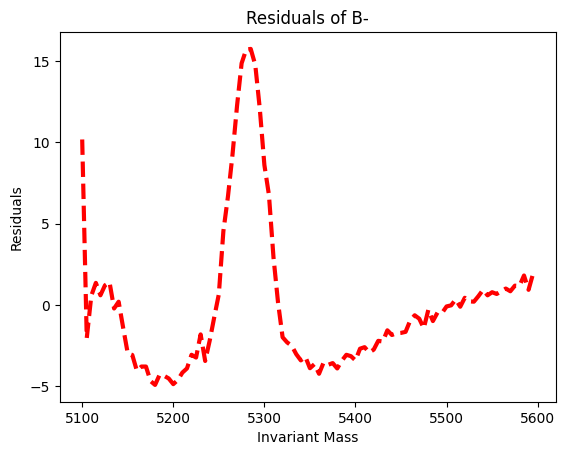

In [30]:
#residuals for negative
plt.figure()
plt.plot(negative_bins[:-1], residual_nve/ np.sqrt(negative_bins[:-1]), color='r', linestyle='dashed', linewidth=3, label='Residuals')
plt.xlabel("Invariant Mass")
plt.ylabel("Residuals")
plt.title("Residuals of B-")


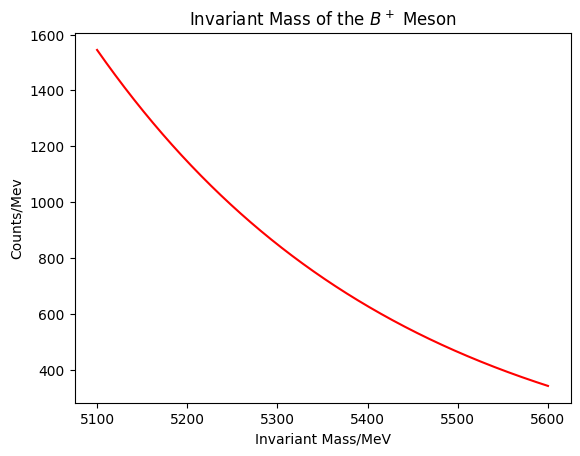

In [31]:
y_signal_pve = clean_data(y_data_pve, [y_plot_1_pve, y_plot_3_pve])

y_signal_nve = clean_data(y_data_nve, [y_plot_1_nve, y_plot_3_nve])

plt.xlabel('Invariant Mass/MeV')
plt.ylabel('Counts/Mev')
plt.title('Invariant Mass of the $B^+$ Meson')
plt.plot(x_data, y_signal_pve, 'r-', label='fit')

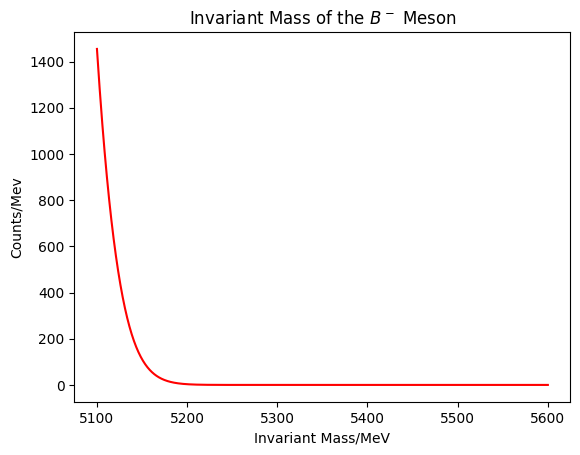

In [32]:
plt.xlabel('Invariant Mass/MeV')
plt.ylabel('Counts/Mev')
plt.title('Invariant Mass of the $B^-$ Meson')
plt.plot(x_data, y_signal_nve, 'r-', label='fit')

In [33]:
def area_under_curve(x_data, y_data):
    area = np.trapz(y_data, x_data)
    #find area using monte carlo method
    
    return area
#find area under a histogram using monte carlo method
def area_monte(x_data, y_data):
    return 0

area_pve = area_under_curve(x_data, y_signal_pve)
area_nve = area_under_curve(x_data, y_signal_nve)
print(f"The area under the curve is {area_pve:g} which is the count rate of the signal.")
print(f"The area under the curve is {area_nve:g} which is the count rate of the signal.")

The area under the curve is 399886 which is the count rate of the signal.
The area under the curve is 29899.5 which is the count rate of the signal.


100,000 events cleaned initial, seed = 0. Leads to 9332.89  area under the curve for B+
100,000 events cleaned initial, seed = 0. Leads to 9045.72 area under the curve for B-


In [34]:
N_plus = area_pve
N_minus =  area_nve

A = (N_plus - N_minus) / (N_plus + N_minus)
unc_assymetry = np.sqrt( 1- A ** 2) / np.sqrt(N_plus + N_minus)
print(f" The CP asymmetry is {A:g} +/- {unc_assymetry:g}.")



 The CP asymmetry is 0.860863 +/- 0.000776162.


In [35]:
def find_indivual(x_data, min=4000, max=6500, name="Inv_mass_Positive"):
    x_data = np.array(x_data)
    inv_mass = (np.where((x_data > min) & (x_data < max), x_data, np.nan))
    plt.hist(inv_mass, bins=100, histtype='step', label=name);   
    values, bins, patches = plt.hist(inv_mass, bins=100)
    x_data = np.linspace(4000, 6000, 100)

    popt, pcov = curve_fit(fit_func_triple, get_bins(bins, values), values, 
                            p0 = [100, 5000, 40, 100, 5300, 5, 10, 1000 ])
    y_data = fit_func_triple(x_data, popt[0], popt[1], popt[2], popt[3], popt[4],
                              popt[5], popt[6], popt[7])

    #take difference between 5271 and the mean of the gaussian fit
    #if the difference is positive, then the signal is positive

    y_plot_1_diff = np.abs(5271 - popt[1])
    y_plot_2_diff = np.abs(5271 - popt[4])

   
    y_plot_1 = gaussian(x_data, popt[0], popt[1], popt[2])
    y_plot_2 = gaussian(x_data, popt[3], popt[4], popt[5])
    y_plot_3 = exponential(x_data, popt[6], popt[7])
    #plot the data

    plt.plot(x_data, y_data, 'r-', label='fit')
    plt.plot(x_data, y_plot_1, 'b-', label='fit')
    plt.plot(x_data, y_plot_2, 'g-', label='fit')
    plt.plot(x_data, y_plot_3, 'y-', label='fit')

    if abs(y_plot_1_diff) < abs(y_plot_2_diff):
        other_dataaset = [y_plot_2, y_plot_3]
    else:
        other_dataaset = [y_plot_1, y_plot_3]


    y_signal = clean_data(y_data, other_dataaset)

    plt.xlabel('Invariant Mass/MeV' + name)
    plt.ylabel('Counts/Mev')
    plt.title('Invariant Mass of the $B^+/-$ Meson' + name)
    plt.plot(x_data, y_signal, 'r-', label='fit')

    return y_signal

def assymetry_func(positve_data, negative_data):
    A = (positve_data - negative_data) / (positve_data + negative_data)
    return A

def find_assymetry(data_mode=3, MAX_EVENTS=1, num_repetitions=1):
    
    pT, pX, pY, pZ, (h1_probpi, h1_probk), (h2_probpi, h2_probk), (h3_probpi, h3_probk), (
    master_probpi, master_probk), inv_mass_positive = read_file(mode=data_mode, MAX_EVENTS=MAX_EVENTS, selection=True,
                                                                   interest="B+")
    del pT, pX, pY, pZ, h1_probpi, h1_probk, h2_probpi, h2_probk, h3_probpi, h3_probk, master_probpi, master_probk

    #take B- data
    pT, pX, pY, pZ, (h1_probpi, h1_probk), (h2_probpi, h2_probk), (h3_probpi, h3_probk), (
    master_probpi, master_probk), inv_mass_negative = read_file(mode=data_mode, MAX_EVENTS=MAX_EVENTS, selection=True,
                                                                     interest="B-")
    
    del pT, pX, pY, pZ, h1_probpi, h1_probk, h2_probpi, h2_probk, h3_probpi, h3_probk, master_probpi, master_probk

    positive_area = []
    negative_area = []

    #randomly sample 3 integers from 1 to million

    random_integers = np.random.randint(1, 1000000, num_repetitions)
    
    for i in random_integers:
        np.random.seed(i)
        plt.hist(inv_mass_positive, bins=100,  histtype='step', label='Invariant Mass');
        positive_area.append(find_indivual(inv_mass_positive, name="Inv_mass_Positive"))
        del inv_mass_positive
        negative_area.append(find_indivual(inv_mass_negative, name="Inv_mass_Negative"))
        del inv_mass_negative
    positive_area_mean = np.mean(positive_area)
    negative_area_mean = np.mean(negative_area)
    print(positive_area_mean, negative_area_mean)
    assymetry = assymetry_func(positive_area_mean, negative_area_mean)
    print(f"The assymetry is given by {assymetry}")
    return assymetry

# find_assymetry(data_mode=2, MAX_EVENTS=10000, num_repetitions=1)


# Crystal Ball function

We will try to fit the crystal ball function now.

In [39]:
#applying min max scaling to the histogram counts
def min_max_scaler(counts):
    counts = np.array(counts)
    #min = np.min(counts)
    max = np.max(counts)
    counts = (counts) 
    return counts

y_data_scaled = min_max_scaler(values)

In [40]:
#letws use the scipy.differential_evolution function to find the best fit parameters
def mse(popt, x_data=get_bins(bins, values), y_data=y_data_scaled):
    y_fit = fit_crystal(x_data,
                        popt[0], popt[1], popt[2],
                        popt[3], popt[4], popt[5], popt[6],
                        popt[7], popt[8], popt[9], popt[10])

    #here x_data = BIN CENTERS OR GET_BINS(BINS, VALUES)
    return np.sum((y_data - y_fit) ** 2)


In [99]:
def constrained_expontential(x, normE, decayE, offsetE):
    result = np.where(x < 5200, 0, (1/decayE) * normE * np.exp(-(x-offsetE)/decayE))
    return result

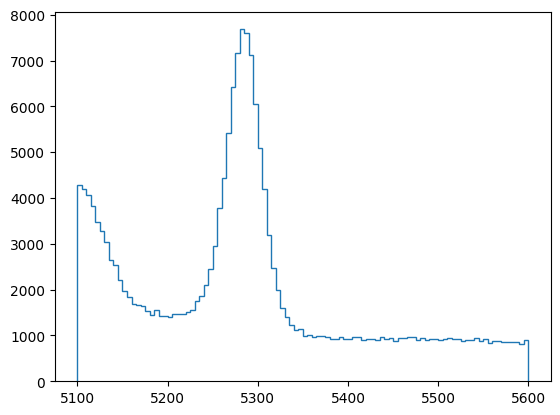

In [229]:
plt.hist(get_bins(bins, values), bins=bins, weights=y_data_scaled, histtype='step', label='Invariant Mass');

In [230]:
#get genetic algorithm initial parameters
from scipy.optimize import differential_evolution
def generate_Initial_Parameters():
    # min and max used for bounds
    gauss_norm_bounds = [0, 8000]
    gauss_mean_bounds = [5000, 5200]
    gauss_sigma_bounds = [1, 101]
    
    crystal_mean_bounds = [5150, 5400]
    crystal_sigma_bounds = [1, 101]
    crystal_alpha_bounds = [1, 10]
    crystal_n_bounds = [1, 10]
    crystal_norm_bounds = [0, 10000]

    exponential_norm_bounds = [0,1000]
    exponential_decay_bounds = [0, 10]
    exponential_offset_bounds = [5100, 5800]

    parameterBounds = []
    parameterBounds.append(gauss_norm_bounds) # seach bounds for popt[0]
    parameterBounds.append(gauss_mean_bounds) # seach bounds for popt[1]
    parameterBounds.append(gauss_sigma_bounds) # seach bounds for popt[2]

    parameterBounds.append(crystal_mean_bounds) # seach bounds for popt[3]
    parameterBounds.append(crystal_sigma_bounds) # seach bounds for popt[4]
    parameterBounds.append(crystal_alpha_bounds) # seach bounds for popt[5]
    parameterBounds.append(crystal_n_bounds) # seach bounds for popt[6]
    parameterBounds.append(crystal_norm_bounds) # seach bounds for popt[7]#
    
    parameterBounds.append(exponential_norm_bounds) # seach bounds for popt[8]
    parameterBounds.append(exponential_decay_bounds) # seach bounds for popt[9]
    parameterBounds.append(exponential_offset_bounds) # seach bounds for popt[10]
    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(mse, parameterBounds, seed=3)
    return result.x


In [231]:

geneticParameters = generate_Initial_Parameters()


/tmp/ipykernel_27743/3387933839.py:17: RuntimeWarning: overflow encountered in scalar power
  A = (n/abs(alpha))**n * np.exp(-alpha**2/2)
/tmp/ipykernel_27743/3387933839.py:25: RuntimeWarning: invalid value encountered in scalar multiply
  data = np.array([N * np.exp(-0.5 * (seperater_val)**2) if seperater_val > -alpha else N * A * (B - seperater_val)**(-n) for seperater_val in seperater_val])
/tmp/ipykernel_27743/3387933839.py:7: RuntimeWarning: overflow encountered in exp
  return np.array( (1 / decay )  * norm * np.exp(-(x-xoffset)/decay) )
/tmp/ipykernel_27743/3387933839.py:7: RuntimeWarning: overflow encountered in multiply
  return np.array( (1 / decay )  * norm * np.exp(-(x-xoffset)/decay) )
/tmp/ipykernel_27743/1526791072.py:9: RuntimeWarning: overflow encountered in square
  return np.sum((y_data - y_fit) ** 2)


In [232]:
geneticParameters

array([7.89256660e+03, 5.09612916e+03, 1.97853250e+01, 5.33239950e+03,
       5.23058831e+01, 1.65216997e+00, 9.47860544e+00, 9.26017854e+02,
       6.39920820e+02, 2.67157481e-02, 5.11396518e+03])

In [24]:
y_data_genetic = fit_crystal(x_data,
                    *geneticParameters)

y_plot_gentic_1 = half_gaussian(x_data, geneticParameters[0], geneticParameters[1], geneticParameters[2])
y_plot_gentic_2 = crystal_ball(x_data, geneticParameters[3], geneticParameters[4], geneticParameters[5], geneticParameters[6], geneticParameters[7])
y_plot_gentic_3 = constrained_expontential(x_data, geneticParameters[8], geneticParameters[9], geneticParameters[10])

plt.hist(get_bins(bins, values), bins=bins, weights=y_data_scaled,histtype='step', label='Invariant Mass')
plt.plot(x_data, y_data_genetic, color='r', linestyle='dashed', linewidth=4, label='Genetic Fit')
plt.plot(x_data, y_plot_gentic_1, color='g', linestyle='dashed', linewidth=1, label='Half-Gaussian')

plt.plot(x_data, y_plot_gentic_2, color='pink', linestyle='dashed', linewidth=1, label='Crystal Ball')
plt.plot(x_data, y_plot_gentic_3, color='y', linestyle='dashed', linewidth=1, label='Exponential')
plt.legend()

NameError: name 'geneticParameters' is not defined

In [27]:

y_data = fit_crystal(   x_data,
                        popt[0], popt[1], popt[2],
                        popt[3], popt[4], popt[5], popt[6],
                        popt[7], popt[8], popt[9], popt[10])
def half_gaussian(x, norm, mean, sigma):
    return np.array( (1 / sigma) * norm * np.exp( -0.5 * ( (x-mean)/sigma )**2 ) * (x > mean) )
y_plot_1 = half_gaussian(x_data, 80000, 5100, 30)
y_plot_2 = crystal_ball(x_data, 5285, 20, 2, 10, 340000)
y_plot_3 = exponential(x_data, 4e+5,700, 5800)

plt.hist(get_bins(bins, values), bins=bins, weights=y_data_scaled, histtype='step', label='Invariant Mass')
plt.plot(x_data, y_plot_1 + y_plot_2 + y_plot_3, color='r', linestyle='dashed', linewidth=4, label='Hand fit')
plt.plot(x_data, y_data, color='r', linestyle='dashed', linewidth=4, label='Fit')
plt.plot(x_data, y_plot_1, color='g', linestyle='dashed', linewidth=1, label='Half-Gaussian')
plt.plot(x_data, y_plot_2, color='b', linestyle='dashed', linewidth=1, label='Crystal Ball')

plt.plot(x_data, y_plot_3, color='y', linestyle='dashed', linewidth=1, label='Exponential')
plt.legend()

IndexError: index 9 is out of bounds for axis 0 with size 9

In [235]:

y_plot_gentic_1 = half_gaussian(x_data, geneticParameters[0], geneticParameters[1], geneticParameters[2])
y_plot_gentic_2 = crystal_ball(x_data, geneticParameters[3], geneticParameters[4], geneticParameters[5], geneticParameters[6], geneticParameters[7])
y_plot_gentic_3 = constrained_expontential(x_data, geneticParameters[8], geneticParameters[9], geneticParameters[10])


In [305]:
initial_values = [  80000, 5100, 30,
                        5287, 20, 2, 10, 340000,        
                        4e+5, 700, 5800 ]
                        
popt, pcov = curve_fit(fit_crystal, get_bins(bins, values), values,

                        p0= initial_values,
                        maxfev=1000000)

# popt, pcov = curve_fit(fit_crystal, get_bins(bins, values), y_data_scaled,
#                         p0 = geneticParameters,
#                         maxfev=1000000)

/tmp/ipykernel_27743/3387933839.py:17: RuntimeWarning: overflow encountered in scalar power
  A = (n/abs(alpha))**n * np.exp(-alpha**2/2)
/tmp/ipykernel_27743/3387933839.py:25: RuntimeWarning: invalid value encountered in scalar multiply
  data = np.array([N * np.exp(-0.5 * (seperater_val)**2) if seperater_val > -alpha else N * A * (B - seperater_val)**(-n) for seperater_val in seperater_val])


In [306]:
print(initial_values)
print(popt)

[80000, 5100, 30, 5287, 20, 2, 10, 340000, 400000.0, 700, 5800]
[8.000e+04 5.100e+03 3.000e+01 5.287e+03 2.000e+01 2.000e+00 1.000e+01
 3.400e+05 4.000e+05 7.000e+02 5.800e+03]


In [26]:
y_data = fit_crystal(   x_data,
                        popt[0], popt[1], popt[2],
                        popt[3], popt[4], popt[5], popt[6],
                        popt[7], popt[8], popt[9], popt[10])

y_plot_1 = half_gaussian(x_data, popt[0], popt[1], popt[2])
y_plot_2 = crystal_ball(x_data, popt[3], popt[4], popt[5], popt[6], popt[7])
y_plot_3 = exponential(x_data, popt[8], popt[9], popt[10])

plt.hist(get_bins(bins, values), bins=bins, weights=y_data_scaled, histtype='step', label='Invariant Mass')

#plt.plot(x_data, y_data, color='r', linestyle='dashed', linewidth=4, label='Fit')
plt.plot(x_data, y_plot_1 + y_plot_2 + y_plot_3, color='r', linestyle='dashed', linewidth=4, label='Hand fit')
plt.plot(x_data, y_plot_1, color='g', linestyle='dashed', linewidth=1, label='Half-Gaussian')
plt.plot(x_data, y_plot_2, color='b', linestyle='dashed', linewidth=1, label='Crystal Ball')
plt.plot(x_data, y_plot_3, color='y', linestyle='dashed', linewidth=1, label='Exponential')
plt.legend()
plt.title("Entire Decays")
plt.xlabel("Invariant Mass (MeV)")
plt.ylabel("Counts/ 2 Mev")

IndexError: index 9 is out of bounds for axis 0 with size 9

/tmp/ipykernel_27743/3387933839.py:17: RuntimeWarning: overflow encountered in scalar power
  A = (n/abs(alpha))**n * np.exp(-alpha**2/2)
/tmp/ipykernel_27743/3387933839.py:25: RuntimeWarning: invalid value encountered in scalar multiply
  data = np.array([N * np.exp(-0.5 * (seperater_val)**2) if seperater_val > -alpha else N * A * (B - seperater_val)**(-n) for seperater_val in seperater_val])


Text(0, 0.5, 'Counts/ 2 Mev')

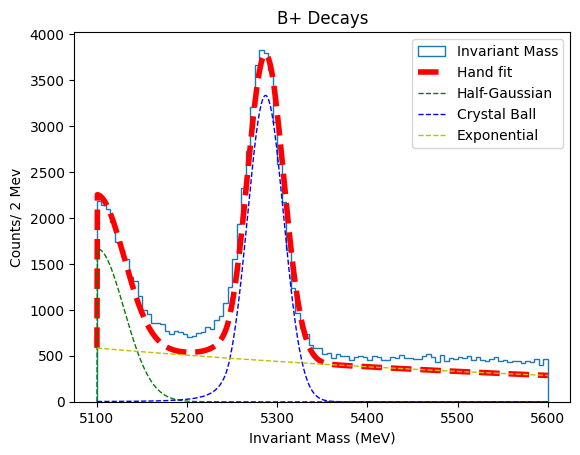

In [301]:
#Lets try the fitting with the positive B+ decays
positive_bins, positive_values, positive_patches, positive_array = get_bins_values(mode="B+", BINS=BIN_NUM, x_min=5100, x_max=5600)
popt_ve, pcov_ve = curve_fit(fit_crystal, get_bins(positive_bins, positive_values), positive_values,
                        p0 = [  50000, 5100, 30,
                                5287, 20, 2, 3, 170000,
                                2e+5, 700, 5600 ],
                        maxfev=1000000)
y_data = fit_crystal(   x_data,
                        popt_ve[0], popt_ve[1], popt_ve[2],
                        popt_ve[3], popt_ve[4], popt_ve[5], popt_ve[6],
                        popt_ve[7], popt_ve[8], popt_ve[9], popt_ve[10])

y_plot_1 = half_gaussian(x_data, popt_ve[0], popt_ve[1], popt_ve[2])
y_plot_2 = crystal_ball(x_data, popt_ve[3], popt_ve[4], popt_ve[5], popt_ve[6], popt_ve[7])
y_plot_3 = exponential(x_data, popt_ve[8], popt_ve[9], popt_ve[10])

plt.hist(get_bins(positive_bins, positive_values), bins=positive_bins, weights=positive_values, histtype='step', label='Invariant Mass')
#plt.plot(x_data, y_data, color='r', linestyle='dashed', linewidth=4, label='Fit')
plt.plot(x_data, y_plot_1 + y_plot_2 + y_plot_3, color='r', linestyle='dashed', linewidth=4, label='Hand fit')
plt.plot(x_data, y_plot_1, color='g', linestyle='dashed', linewidth=1, label='Half-Gaussian')
plt.plot(x_data, y_plot_2, color='b', linestyle='dashed', linewidth=1, label='Crystal Ball')
plt.plot(x_data, y_plot_3, color='y', linestyle='dashed', linewidth=1, label='Exponential')
plt.legend()

plt.title("B+ Decays")
plt.xlabel("Invariant Mass (MeV)")
plt.ylabel("Counts/ 2 Mev")

In [302]:
print(popt)
print(popt_ve)

[8.000e+04 5.100e+03 3.000e+01 5.287e+03 2.000e+01 2.000e+00 1.000e+01
 3.400e+05 4.000e+05 7.000e+02 5.800e+03]
[5.000e+04 5.100e+03 3.000e+01 5.287e+03 2.000e+01 2.000e+00 3.000e+00
 1.700e+05 2.000e+05 7.000e+02 5.600e+03]


# 2 Body Resonance Removal


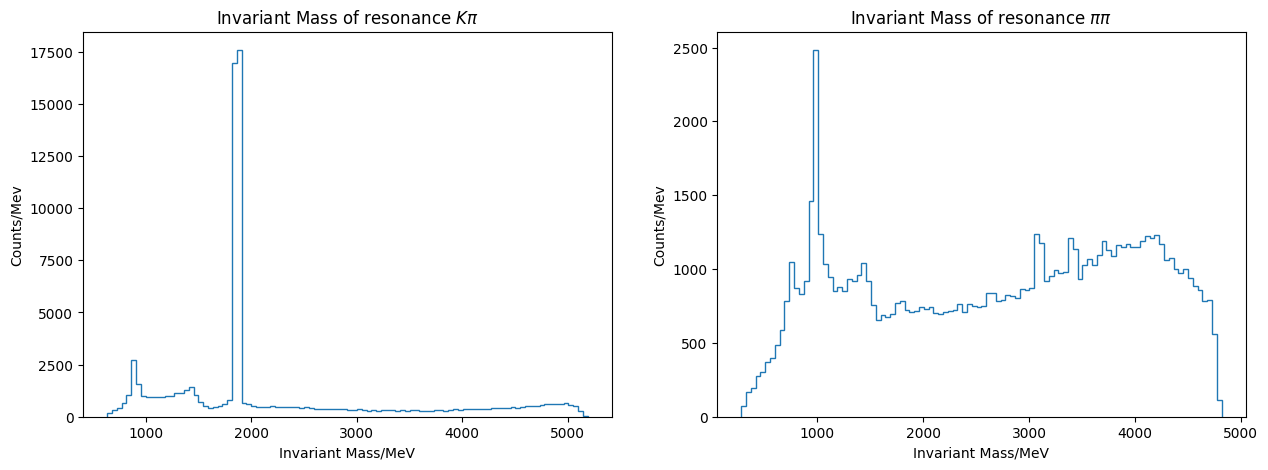

In [8]:
two_body_resonance = np.genfromtxt('/workspaces/labs_yr3/matter_antimatter/data/two_body_resonance.csv', delimiter=',')
#plot two figures side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hist(two_body_resonance[:,0], bins=100,  histtype='step', label='Invariant Mass');
ax1.set_title('Invariant Mass of resonance $K \pi$')
ax1.set_xlabel('Invariant Mass/MeV')
ax1.set_ylabel('Counts/Mev')
ax2.set_title('Invariant Mass of resonance $\pi \pi$')
ax2.set_xlabel('Invariant Mass/MeV')
ax2.set_ylabel('Counts/Mev')
ax2.hist(two_body_resonance[:,1], bins=100,  histtype='step', label='Invariant Mass');
#plot two histograms for each of the two body resonances


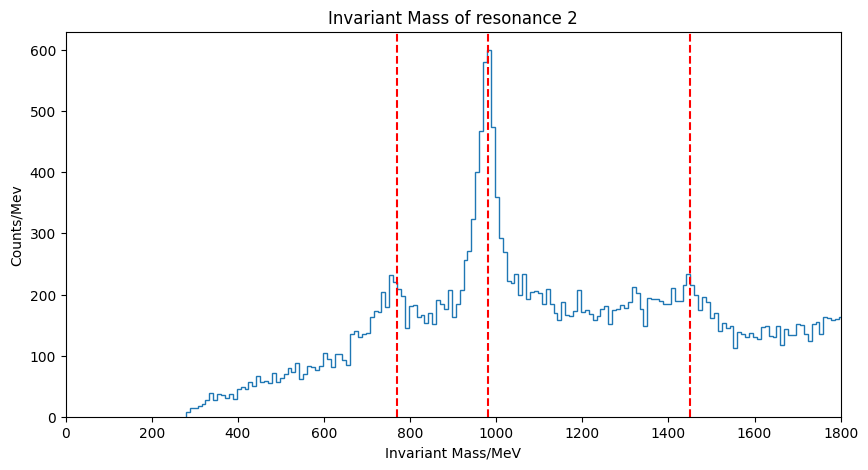

In [9]:
#change figure size
plt.figure(figsize=(10, 5))

plt.hist(two_body_resonance[:,1], bins=500,  histtype='step', label='Invariant Mass');
#set the range of the histogram
plt.xlim(0, 1800)
plt.xlabel('Invariant Mass/MeV')
plt.ylabel('Counts/Mev')
plt.title('Invariant Mass of resonance 2')
#set a vertical line at the peak of the histogram
plt.axvline(x=770, color='r', linestyle='--')
plt.axvline(x=980, color='r', linestyle='--')
plt.axvline(x=1450, color='r', linestyle='--')

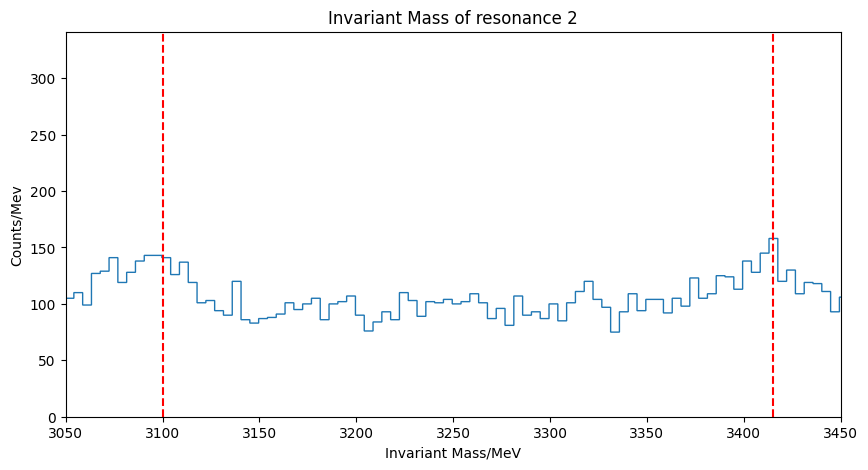

In [10]:
plt.figure(figsize=(10, 5))

plt.hist(two_body_resonance[:,1], bins=1000,  histtype='step', label='Invariant Mass');
#set the range of the histogram
plt.xlim(3050, 3450)
plt.xlabel('Invariant Mass/MeV')
plt.ylabel('Counts/Mev')
plt.title('Invariant Mass of resonance 2')
#set a vertical line at the peak of the histogram
plt.axvline(x=3100, color='r', linestyle='--')
plt.axvline(x=3415, color='r', linestyle='--')
plt.axvline(x=1450, color='r', linestyle='--')

Other resonance plot

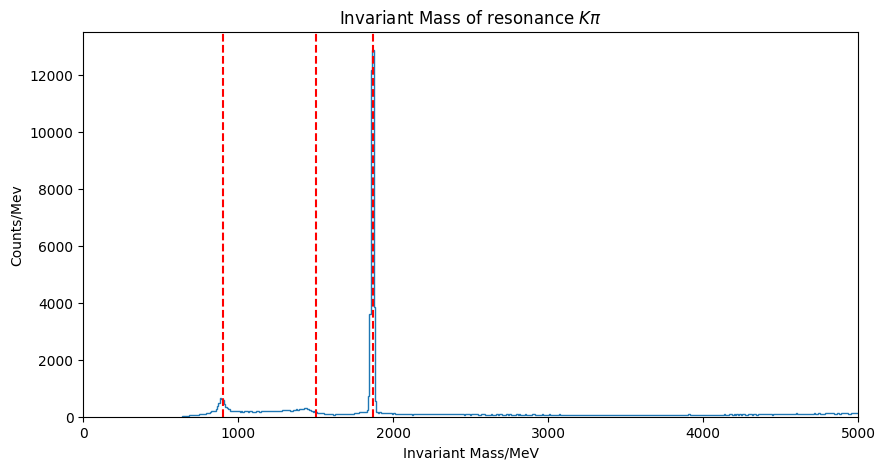

In [11]:
plt.figure(figsize=(10, 5))

plt.hist(two_body_resonance[:,0], bins=500,  histtype='step', label='Invariant Mass');
#set the range of the histogram
plt.xlim(0, 5000)
plt.xlabel('Invariant Mass/MeV')
plt.ylabel('Counts/Mev')
plt.title('Invariant Mass of resonance $K \pi$')
plt.axvline(x=900, color='r', linestyle='--')
plt.axvline(x=1500, color='r', linestyle='--')
plt.axvline(x=1870, color='r', linestyle='--')

#set a vertical line at the peak of the histogram
#plt.axvline(x=770, color='r', linestyle='--')
#plt.axvline(x=980, color='r', linestyle='--')
#plt.axvline(x=1450, color='r', linestyle='--')

(0.0, 1200.0)

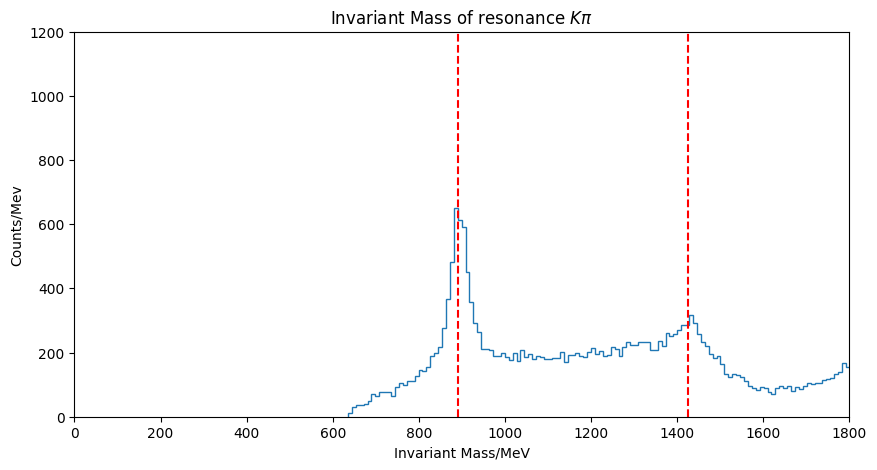

In [12]:
plt.figure(figsize=(10, 5))

plt.hist(two_body_resonance[:,0], bins=500,  histtype='step', label='Invariant Mass');
#set the range of the histogram
plt.xlim(0, 1800)
plt.xlabel('Invariant Mass/MeV')
plt.ylabel('Counts/Mev')
plt.title('Invariant Mass of resonance $K \pi$')
plt.axvline(x=890, color='r', linestyle='--')
plt.axvline(x=1425, color='r', linestyle='--')
#plt.axvline(x=1870, color='r', linestyle='--')
plt.ylim(0, 1200)
#set a vertical line at the peak of the histogram
#plt.axvline(x=770, color='r', linestyle='--')
#plt.axvline(x=980, color='r', linestyle='--')
#plt.axvline(x=1450, color='r', linestyle='--')

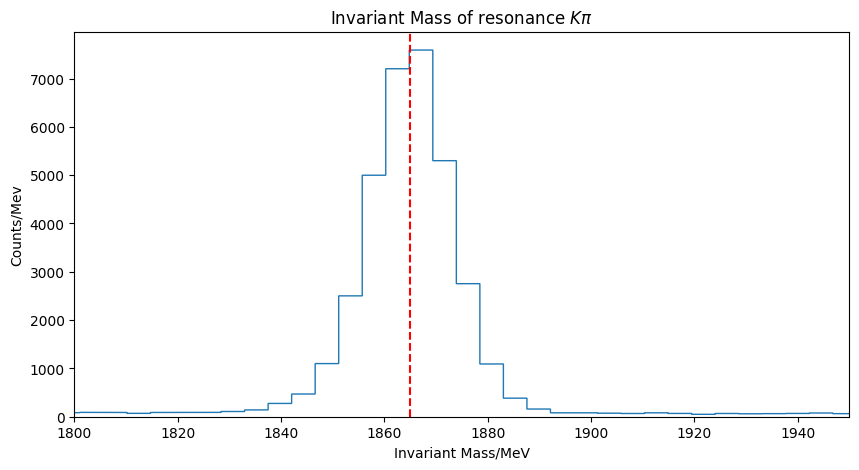

In [13]:
plt.figure(figsize=(10, 5))

plt.hist(two_body_resonance[:,0], bins=1000,  histtype='step', label='Invariant Mass');
#set the range of the histogram
plt.xlim(1800, 1950)
plt.xlabel('Invariant Mass/MeV')
plt.ylabel('Counts/Mev')
plt.title('Invariant Mass of resonance $K \pi$')
#plt.axvline(x=890, color='r', linestyle='--')
#plt.axvline(x=1425, color='r', linestyle='--')
plt.axvline(x=1865, color='r', linestyle='--')
#plt.ylim(0, 1200)

(0.0, 300.0)

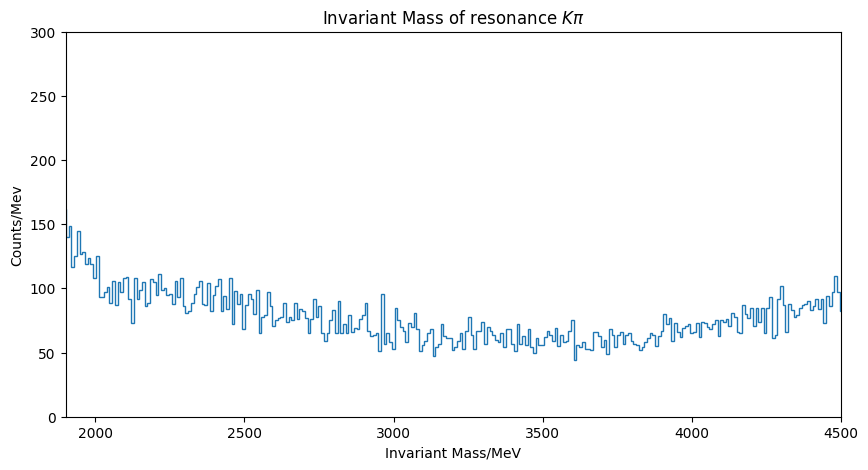

In [14]:
plt.figure(figsize=(10, 5))

plt.hist(two_body_resonance[:,0], bins=500,  histtype='step', label='Invariant Mass');
#set the range of the histogram
plt.xlim(1900, 4500)
plt.xlabel('Invariant Mass/MeV')
plt.ylabel('Counts/Mev')
plt.title('Invariant Mass of resonance $K \pi$')
#plt.axvline(x=890, color='r', linestyle='--')
#plt.axvline(x=1425, color='r', linestyle='--')
plt.axvline(x=1865, color='r', linestyle='--')
plt.ylim(0, 300)

# Removing Plots

# Dalitz Plots 

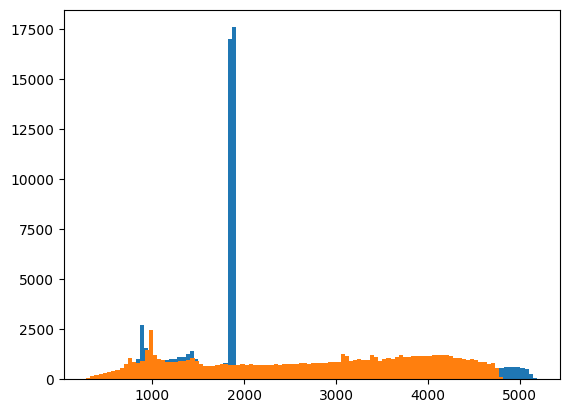

In [15]:
plt.hist(two_body_resonance[:,0],bins=100);
plt.hist(two_body_resonance[:,1], bins=100);

def mev_to_gev(mass):
    return mass/1000

Text(0, 0.5, 'Invariant Mass of resonance $\\pi \\pi$')

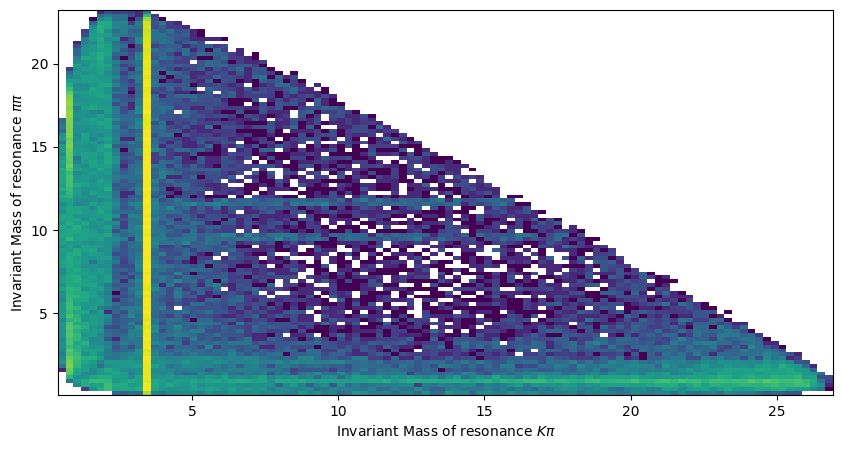

In [16]:
plt.figure(figsize=(10, 5))

plt.hist2d(np.square(mev_to_gev(two_body_resonance[:,0])),
            np.square(mev_to_gev(two_body_resonance[:,1])),
          bins=100,   label='Invariant Mass',
          norm=colors.LogNorm());
#increase the number of ticks on the x axis
#plt.xticks(np.arange(0, 5000, 300));
#add a vertical line on 
plt.xlabel('Invariant Mass of resonance $K \pi$')
plt.ylabel('Invariant Mass of resonance $\pi \pi$')

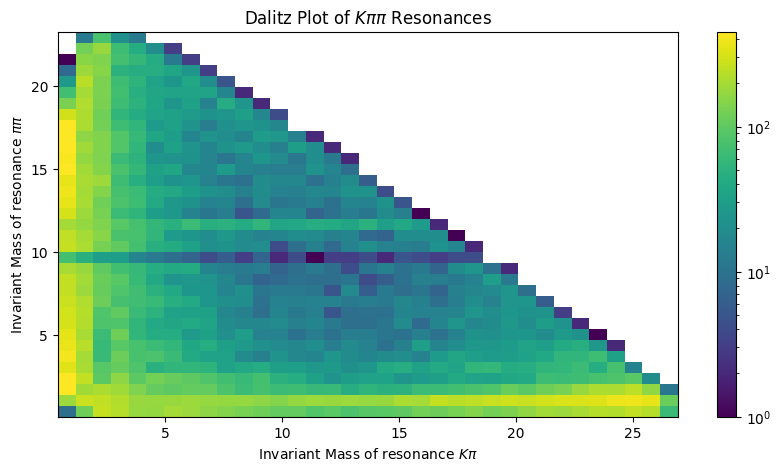

In [20]:
#get rid of background events and then plot them again. 
filtered_resonances = np.genfromtxt('/workspaces/labs_yr3/two_body_resonance_filtered (1).csv', delimiter=',')
invariant_mass_resonance = np.genfromtxt('/workspaces/labs_yr3/inv_mass_filtered.csv', delimiter=',')
#plot the resonances in a Dalitz plot
plt.figure(figsize=(10, 5))
plt.hist2d(np.square(mev_to_gev(filtered_resonances[:,0])),
           np.square(mev_to_gev(filtered_resonances[:,1])),
            bins=35,   label='Invariant Mass', 
            norm=colors.LogNorm());
#increase the number of ticks on the x axis
plt.xlabel('Invariant Mass of resonance $K \pi$')
plt.ylabel('Invariant Mass of resonance $\pi \pi$')
plt.title('Dalitz Plot of $K \pi \pi$ Resonances')
#add a colorbar for density
plt.colorbar()


[ 5.08253333e+14  3.15439242e+03  3.08511413e+02  1.29684320e+05
  5.28403468e+03  1.99520796e+01 -5.73189361e+11 -1.39957521e+11
 -7.60141922e+11]
16184.220840172673


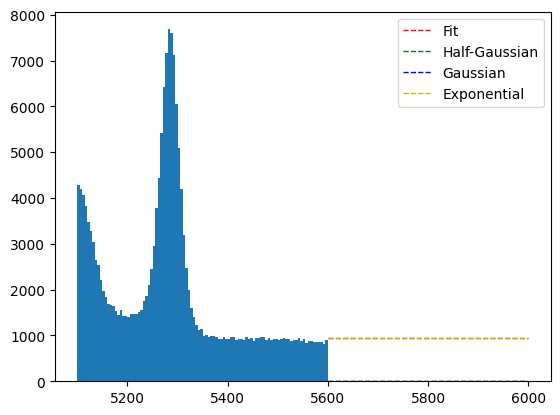

In [23]:
#plot the
popt, pcov = curve_fit(fit_func_half, get_bins(bins, values), values,
            p0 = [1000, 5100, 5, 1000, 5300, 10, 10, 5, 5100 ],
                        maxfev=1000000)
print(popt)

y_data = fit_func_half(x_data, popt[0], popt[1], popt[2],
                        popt[3], popt[4], popt[5],
                        popt[6], popt[7], popt[8])
y_plot_1 = half_gaussian(x_data, popt[0], popt[1], popt[2])
y_plot_2 = gaussian(x_data, popt[3], popt[4], popt[5])
y_plot_3 = exponential(x_data, popt[6], popt[7], popt[8])

norm_area_counts = popt[3]


plt.hist(invariant_mass_numpy, bins=BIN_NUM)
plt.plot(x_data, y_data, color='r', linestyle='dashed', linewidth=1, label='Fit')
plt.plot(x_data, y_plot_1, color='g', linestyle='dashed', linewidth=1, label='Half-Gaussian')
plt.plot(x_data, y_plot_2, color='b', linestyle='dashed', linewidth=1, label='Gaussian')
plt.plot(x_data, y_plot_3, color='y', linestyle='dashed', linewidth=1, label='Exponential')
plt.legend()
#compute reduced chi squared for the fit
chi_squared = np.sum((values - fit_func_half(get_bins(bins, values), popt[0], popt[1], popt[2],
                        popt[3], popt[4], popt[5],  
                        popt[6], popt[7], popt[8]))**2) 
reduced_chi_squared = chi_squared/(len(values) - 9)
print(reduced_chi_squared)

In [25]:
#calcualte the extended log likelihood for the fit
extended_log_likelihood = np.sum(np.log(fit_func_half(get_bins(bins, values), popt[0], popt[1], popt[2],
                        popt[3], popt[4], popt[5],  
                        popt[6], popt[7], popt[8])))    
print(extended_log_likelihood)

732.9825552395679


Optimal x_min:  5242
Optimal x_max:  5328
Optimal significance:  496.33935246256334
Signal region is taken from the previous calculations.

In [26]:
#find the signal_region
signal_x_vals = np.linspace(5242, 5328, 1000)
signal_region_exponential = exponential(signal_x_vals, popt[6], popt[7], popt[8])
#integrate the exponential
signal_region_exponential_integral = np.trapz(signal_region_exponential, signal_x_vals)

side_signal_vals = np.linspace(5400, 5600, 1000)
side_signal_region_exponential = exponential(side_signal_vals, popt[6], popt[7], popt[8])
side_signal_region_exponential_integral = np.trapz(side_signal_region_exponential, side_signal_vals)
print('The area of the exponential is: ', signal_region_exponential_integral)
print("The area of the side signal region is: ", side_signal_region_exponential_integral)

#find the normalisation scale:
ratio_of_regions = side_signal_region_exponential_integral/signal_region_exponential_integral
print('The ratio of the side signal region to the signal region is: ', ratio_of_regions)


The area of the exponential is:  80455.34845419851
The area of the side signal region is:  187105.46180881961
The ratio of the side signal region to the signal region is:  2.32558139892135


In [27]:
#SELECT THE EVENTS IN THE SIGNAL REGION BY LOOKING AT THE INVARIANT MASSES.

signal_boundaries = [5242, 5328]
side_boundaries = [5400, 5600]

#select the events in the signal region
signal_region_arguments = np.argwhere((invariant_mass_resonance > signal_boundaries[0]) & (
    invariant_mass_resonance < signal_boundaries[1]))
signal_events = invariant_mass_resonance[signal_region_arguments]
signal_two_body = filtered_resonances[signal_region_arguments]

#select the events in the side signal region
side_signal_two_body = np.genfromtxt('/workspaces/labs_yr3/matter_antimatter/data/filtered_post_resonance/two_body_resonance_combinatorial.csv', delimiter=',')
side_signal_region_arguments = np.argwhere((invariant_mass_resonance > side_boundaries[0]) & (
    invariant_mass_resonance < side_boundaries[1]))
print(side_signal_region_arguments)
side_signal_events = invariant_mass_resonance[side_signal_region_arguments]
#side_signal_two_body = filtered_resonances[side_signal_region_arguments]

signal_two_body = np.squeeze(signal_two_body, axis=1)
#side_signal_two_body = np.squeeze(side_signal_two_body, axis=1)
print(np.shape(side_signal_two_body))

[]
(36362, 2)


In [158]:
np.max(invariant_mass_resonance)

5332.993325791509

# Signal region Dalitz Plot

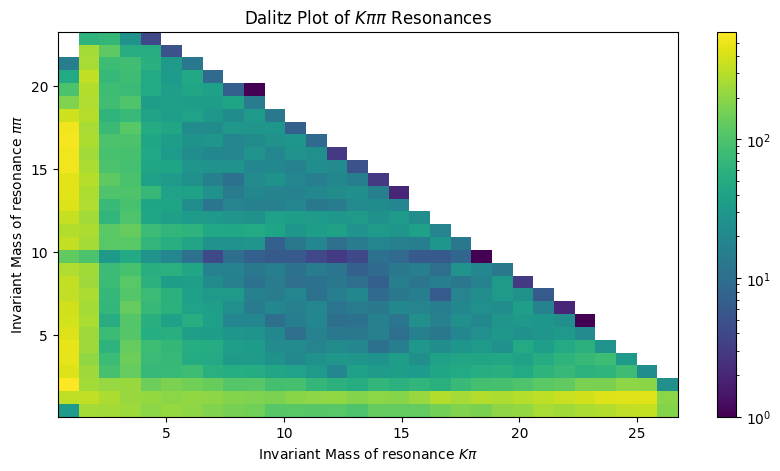

In [28]:
plt.figure(figsize=(10, 5))
plt.hist2d(np.square(mev_to_gev(signal_two_body[:,0])),
           np.square(mev_to_gev(signal_two_body[:,1])),
            bins=30,   label='Invariant Mass', 
            norm=colors.LogNorm());
#increase the number of ticks on the x axis
plt.xlabel('Invariant Mass of resonance $K \pi$')
plt.ylabel('Invariant Mass of resonance $\pi \pi$')
plt.title('Dalitz Plot of $K \pi \pi$ Resonances')
#add a colorbar for density
plt.colorbar()

# Dalitz Background

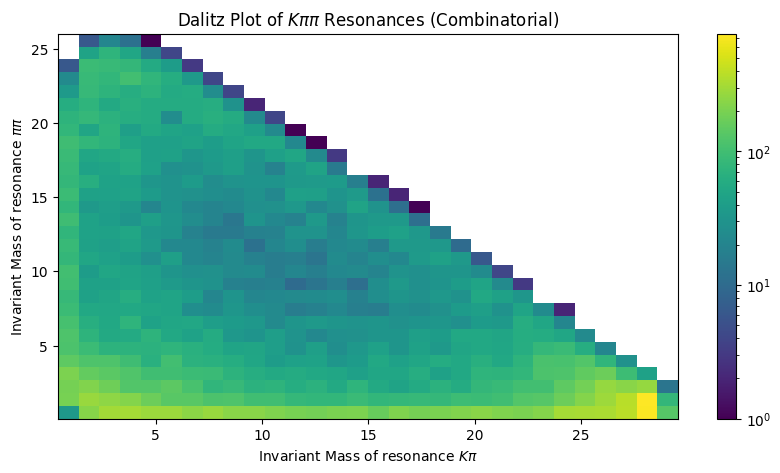

In [29]:
plt.figure(figsize=(10, 5))

plt.hist2d(np.square(mev_to_gev(side_signal_two_body[:,0])),
           np.square(mev_to_gev(side_signal_two_body[:,1])),
            bins=30,   label='Invariant Mass', 
            norm=colors.LogNorm());
#increase the number of ticks on the x axis
plt.xlabel('Invariant Mass of resonance $K \pi$')
plt.ylabel('Invariant Mass of resonance $\pi \pi$')
plt.title('Dalitz Plot of $K \pi \pi$ Resonances (Combinatorial)')
#add a colorbar for density
plt.colorbar()

In [164]:
#subtract the two histograms from each other
def subtract_two_hist(hist_1, hist_2, multiplier_2):
    hist_1 = np.squeeze(hist_1)
    hist_2 = np.squeeze(hist_2)
    hist_2 = hist_2*multiplier_2
    hist_1 = hist_1 - hist_2
    return hist_1

### Manipulation of 2D histograms

The following is an example code to demonstrate manipulation of the content of 2D histograms. It first produces two dummy histograms before working out the bin centres, subtracting the histogram contents, and finally plotting. The subtraction bit can of course be replaced by more complex operations as well.

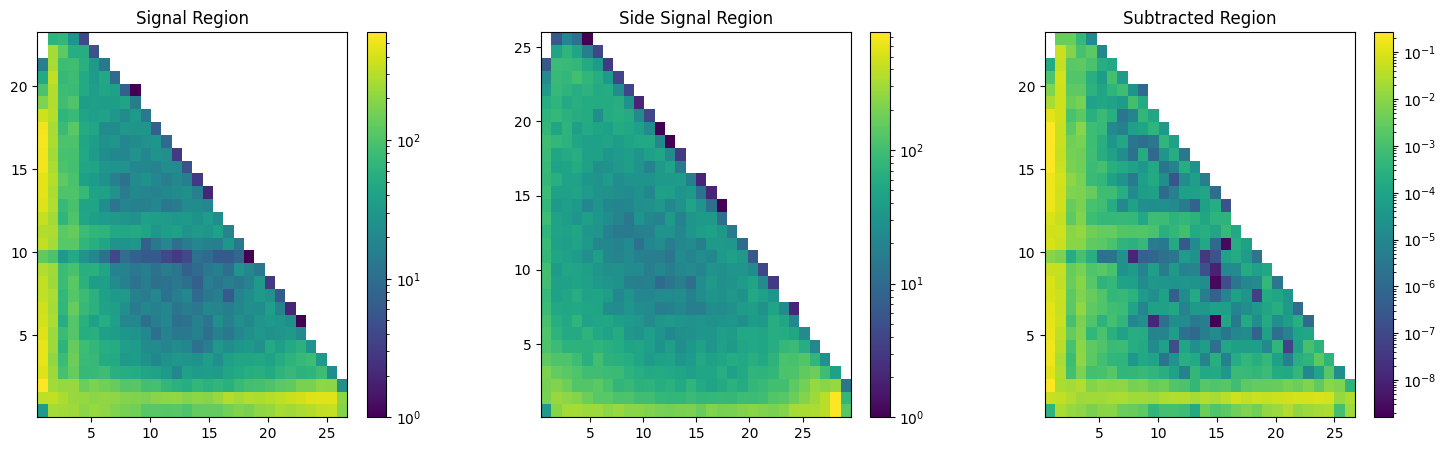

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

h2d1 = ax[0].hist2d(
        np.square(mev_to_gev(signal_two_body[:,0])),
        np.square(mev_to_gev(signal_two_body[:,1])),
            bins=30,   label='Invariant Mass Signal',
            norm=colors.LogNorm())
h2d2 = ax[1].hist2d(np.square(mev_to_gev(side_signal_two_body[:,0])),
                    np.square(mev_to_gev( side_signal_two_body[:,1])),
            bins=30,   label='Invariant Mass Side Signal',
            norm=colors.LogNorm())  

ax[0].set_title('Signal Region')
ax[1].set_title('Side Signal Region')
ax[2].set_title('Subtracted Region')
# first calculate the bin centres from the bin boundaries of the hist2d object
xcentres = []
ycentres = []
for a,b in zip(h2d1[1][0:-1],h2d1[1][1:]):
    for c,d in zip(h2d1[2][0:-1],h2d1[2][1:]):
        xcentres.append( (a+b)/2 )
        ycentres.append( (c+d)/2 )

# now extract the weights, that is the bin contents
w1 = (np.array(h2d1[0])).flatten()
w2 = (np.array(h2d2[0])).flatten()
w2 = w2 * (1/ratio_of_regions)
wsub = np.subtract(w1,w2) # subtract bin content of two histograms

# produce the new histogram
h2d3 = ax[2].hist2d(xcentres,ycentres,weights=np.square(mev_to_gev(wsub)), bins = [h2d1[1],h2d1[2]],
            norm=colors.LogNorm()) # recycle the binning from above

# plot the lot
fig.colorbar(h2d1[3],ax=ax[0], norm=colors.LogNorm()) # let's add the colour scale for histo 1
fig.colorbar(h2d2[3],ax=ax[1], norm=colors.LogNorm()) # let's add the colour scale for histo 2
fig.colorbar(h2d3[3],ax=ax[2], norm=colors.LogNorm()) # let's add the colour scale for histo 3

# Assymetry Dalitz Plots

In [31]:
def get_bins_values(mode="B+", BINS=100, x_min=5100, x_max=5800, data_generation = 1):

    if mode == "B+":
        dataset = np.genfromtxt('/workspaces/labs_yr3/matter_antimatter/data/inv_mass_positive_two.csv', delimiter=',')
    elif mode == "B-":
        dataset = np.genfromtxt('/workspaces/labs_yr3/matter_antimatter/data/inv_mass_negative_two.csv', delimiter=',')

    else:
        if data_generation == 1:

            dataset = np.genfromtxt('/workspaces/labs_yr3/data/inv_mass.csv', delimiter=',')
        else:
            dataset = np.genfromtxt('/workspaces/labs_yr3/matter_antimatter/data/inv_mass _second.csv', delimiter=',')
    #x_data = np.linspace(x_min, x_max, BINS)
    invariant_mass_numpy = np.array(dataset)
    invariant_mass_numpy = np.where((
        invariant_mass_numpy > x_min) & (
        invariant_mass_numpy < x_max), invariant_mass_numpy, np.nan)
    values, bins, patches = plt.hist(invariant_mass_numpy, bins=BIN_NUM);
    plt.close()
    return bins, values, patches, invariant_mass_numpy


In [32]:
#lets first load the filtered data
positive_bins, positive_values, positive_patches, positive_array = get_bins_values(mode="B+", BINS=BIN_NUM, x_min=5100, x_max=5800)
negative_bins, negative_values, negative_patches, negative_array = get_bins_values(mode="B-", BINS=BIN_NUM, x_min=5100, x_max=5800)

# popt, pcov = curve_fit(fit_func, get_bins(general_bins, general_values),
#  general_array, p0 = [1000, 5100, 5, 1000, 5200, 10, 10, 5, 5100 ],
#     maxfev=10000)
popt_pve, pcov_pve = curve_fit(fit_func_half, get_bins(positive_bins, positive_values),
                                positive_values, p0 = [ 1000, 5100, 5,
                                                        1000, 5200, 10, 10, 5, 5100 ],
                                                        maxfev=10000)
print(popt_pve)

popt_nve , pcov_nve = curve_fit(fit_func_half, get_bins(negative_bins, negative_values), negative_values,
                        p0 = [1000, 5100, 5, 1000, 5200, 10, 10, 5, 5100 ],
                        maxfev=100000)

y_data_pve = fit_func_half(x_data, popt_pve[0], popt_pve[1], popt_pve[2],
                        popt_pve[3], popt_pve[4], popt_pve[5],
                        popt_pve[6], popt_pve[7], popt_pve[8])
y_data_nve = fit_func_half(x_data, popt_nve[0], popt_nve[1], popt_nve[2],
                        popt_nve[3], popt_nve[4], popt_nve[5],
                        popt_nve[6], popt_nve[7], popt_nve[8])

                        

positive_bin_width = (np.nanmax(positive_bins) - np.nanmin(positive_bins)) / BIN_NUM
positve_norm_count = popt_pve[3]

negative_bin_width = (np.nanmax(negative_bins) - np.nanmin(negative_bins)) / BIN_NUM
negative_norm_count = popt_nve[3]
positive_signal_count = positive_bin_width * positve_norm_count
negative_signal_count = negative_bin_width * negative_norm_count



[6.77199943e+04 5.09505486e+03 3.28643482e+01 8.61246399e+04
 5.28394387e+03 1.93959824e+01 1.68864451e+08 8.26138335e+02
 7.76341958e+02]


In [33]:
#find the signal_region
signal_x_vals = np.linspace(5242, 5328, 1000)
signal_region_exponential = exponential(signal_x_vals, popt_pve[6], popt_pve[7], popt_pve[8])
#integrate the exponential
signal_region_exponential_integral = np.trapz(signal_region_exponential, signal_x_vals)

side_signal_vals = np.linspace(5400, 5600, 1000)
side_signal_region_exponential = exponential(side_signal_vals, popt_pve[6], popt_pve[7], popt_pve[8])
side_signal_region_exponential_integral = np.trapz(side_signal_region_exponential, side_signal_vals)
print('The area of the exponential is: ', signal_region_exponential_integral)
print("The area of the side signal region is: ", side_signal_region_exponential_integral)

#find the normalisation scale:
ratio_of_regions_ve = side_signal_region_exponential_integral/signal_region_exponential_integral
print('The ratio of the side signal region to the signal region is: ', ratio_of_regions)

signal_boundaries = [5242, 5328]
side_boundaries = [5400, 5600]

#select the events in the signal region
signal_region_arguments = np.argwhere((invariant_mass_resonance > signal_boundaries[0]) & (
    invariant_mass_resonance < signal_boundaries[1]))
signal_events = invariant_mass_resonance[signal_region_arguments]
signal_two_body = filtered_resonances[signal_region_arguments]

#select the events in the side signal region
side_signal_two_body_pve = np.genfromtxt('/workspaces/labs_yr3/matter_antimatter/data/filtered_by_type/two_body_resonance_combinatorial_Bplus.csv',
                                      delimiter=',')

side_signal_events_pve = invariant_mass_resonance[side_signal_region_arguments]
#side_signal_two_body = filtered_resonances[side_signal_region_arguments]

signal_two_body_pve = np.squeeze(signal_two_body, axis=1)
#side_signal_two_body = np.squeeze(side_signal_two_body, axis=1)
print(np.shape(side_signal_two_body_pve))

The area of the exponential is:  74991.769894116
The area of the side signal region is:  134705.4829412758
The ratio of the side signal region to the signal region is:  2.32558139892135
(18628, 2)


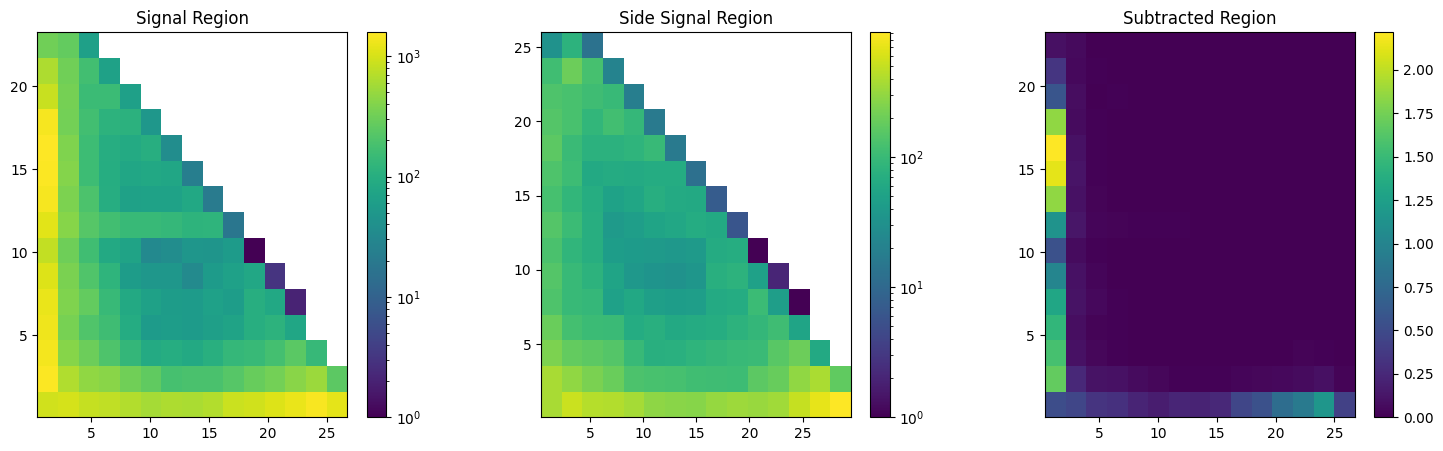

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

h2d1 = ax[0].hist2d(
        np.square(mev_to_gev(signal_two_body_pve[:,0])),
        np.square(mev_to_gev(signal_two_body_pve[:,1])),
            bins=15,   label='Invariant Mass Signal',
            norm=colors.LogNorm())
h2d2 = ax[1].hist2d(np.square(mev_to_gev(side_signal_two_body_pve[:,0])),
                    np.square(mev_to_gev( side_signal_two_body_pve[:,1])),
            bins=15,   label='Invariant Mass Side Signal',
            norm=colors.LogNorm())  

ax[0].set_title('Signal Region')
ax[1].set_title('Side Signal Region')
ax[2].set_title('Subtracted Region')
# first calculate the bin centres from the bin boundaries of the hist2d object
xcentres = []
ycentres = []
for a,b in zip(h2d1[1][0:-1],h2d1[1][1:]):
    for c,d in zip(h2d1[2][0:-1],h2d1[2][1:]):
        xcentres.append( (a+b)/2 )
        ycentres.append( (c+d)/2 )

# now extract the weights, that is the bin contents
w1 = (np.array(h2d1[0])).flatten()
w2 = (np.array(h2d2[0])).flatten()
w2 = w2 * (1/ratio_of_regions_ve)
wsub = np.subtract(w1,w2) # subtract bin content of two histograms

# produce the new histogram
cleaned_positive_dalitz = ax[2].hist2d(xcentres,ycentres,weights=np.square(mev_to_gev(wsub)), bins = [h2d1[1],h2d1[2]],
            ) # recycle the binning from above

# plot the lot
fig.colorbar(h2d1[3],ax=ax[0], norm=colors.LogNorm()) # let's add the colour scale for histo 1
fig.colorbar(h2d2[3],ax=ax[1], norm=colors.LogNorm()) # let's add the colour scale for histo 2
fig.colorbar(cleaned_positive_dalitz[3],ax=ax[2], norm=colors.LogNorm()) # let's add the colour scale for histo 3

# B - Dalitz

In [35]:
signal_x_vals = np.linspace(5242, 5328, 1000)
signal_region_exponential = exponential(signal_x_vals, popt_nve[6], popt_nve[7], popt_nve[8])
#integrate the exponential
signal_region_exponential_integral = np.trapz(signal_region_exponential, signal_x_vals)

side_signal_vals = np.linspace(5400, 5600, 1000)
side_signal_region_exponential = exponential(side_signal_vals, popt_nve[6], popt_nve[7], popt_nve[8])
side_signal_region_exponential_integral = np.trapz(side_signal_region_exponential, side_signal_vals)
print('The area of the exponential is: ', signal_region_exponential_integral)
print("The area of the side signal region is: ", side_signal_region_exponential_integral)

#find the normalisation scale:
ratio_of_regions_nve = side_signal_region_exponential_integral/signal_region_exponential_integral
print('The ratio of the side signal region to the signal region is: ', ratio_of_regions)

signal_boundaries = [5242, 5328]
side_boundaries = [5400, 5600]

#select the events in the signal region
signal_region_arguments = np.argwhere((invariant_mass_resonance > signal_boundaries[0]) & (
    invariant_mass_resonance < signal_boundaries[1]))
signal_events = invariant_mass_resonance[signal_region_arguments]
signal_two_body = filtered_resonances[signal_region_arguments]

#select the events in the side signal region
side_signal_two_body_nve = np.genfromtxt('/workspaces/labs_yr3/matter_antimatter/data/filtered_by_type/two_body_resonance_combinatorial_Bminus.csv',
                                      delimiter=',')

side_signal_events_nve = invariant_mass_resonance[side_signal_region_arguments]
#side_signal_two_body = filtered_resonances[side_signal_region_arguments]

signal_two_body_nve = np.squeeze(signal_two_body, axis=1)
#side_signal_two_body = np.squeeze(side_signal_two_body, axis=1)
print(np.shape(side_signal_two_body_pve))

The area of the exponential is:  73254.6278405734
The area of the side signal region is:  127696.36622808996
The ratio of the side signal region to the signal region is:  2.32558139892135
(18628, 2)


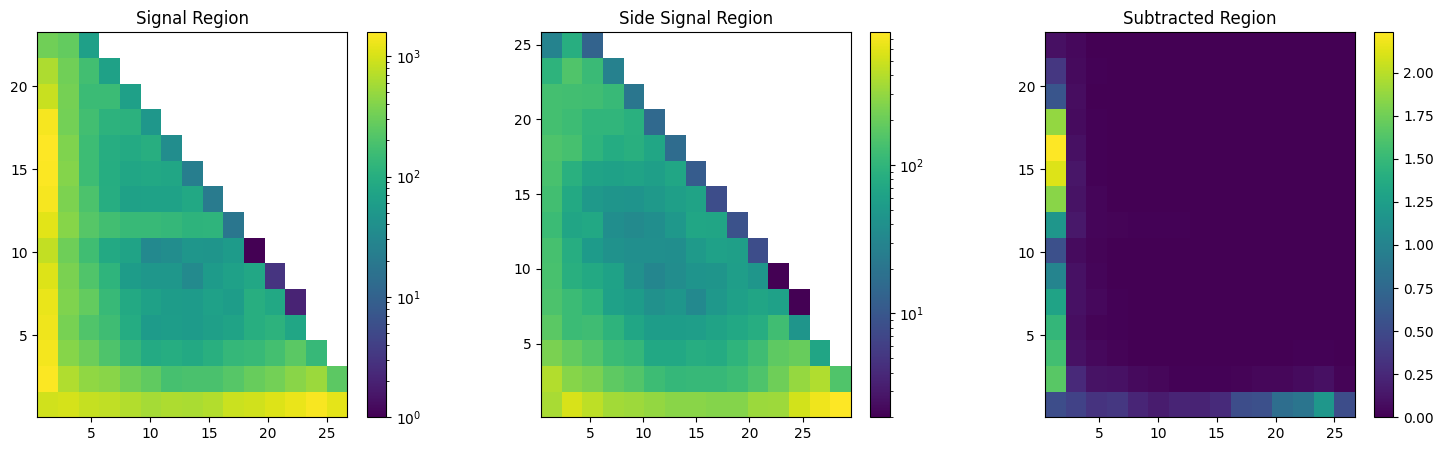

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

h2d1 = ax[0].hist2d(
        np.square(mev_to_gev(signal_two_body_nve[:,0])),
        np.square(mev_to_gev(signal_two_body_nve[:,1])),
            bins=15,   label='Invariant Mass Signal',
            norm=colors.LogNorm())
h2d2 = ax[1].hist2d(np.square(mev_to_gev(side_signal_two_body_nve[:,0])),
                    np.square(mev_to_gev( side_signal_two_body_nve[:,1])),
            bins=15,   label='Invariant Mass Side Signal',
            norm=colors.LogNorm())  

ax[0].set_title('Signal Region')
ax[1].set_title('Side Signal Region')
ax[2].set_title('Subtracted Region')
# first calculate the bin centres from the bin boundaries of the hist2d object
xcentres = []
ycentres = []
for a,b in zip(h2d1[1][0:-1],h2d1[1][1:]):
    for c,d in zip(h2d1[2][0:-1],h2d1[2][1:]):
        xcentres.append( (a+b)/2 )
        ycentres.append( (c+d)/2 )

# now extract the weights, that is the bin contents
w1 = (np.array(h2d1[0])).flatten()
w2 = (np.array(h2d2[0])).flatten()
w2 = w2 * (1/ratio_of_regions_nve)
wsub = np.subtract(w1,w2) # subtract bin content of two histograms

# produce the new histogram
cleaned_negative_dalitz = ax[2].hist2d(xcentres,ycentres,weights=np.square(mev_to_gev(wsub)), bins = [h2d1[1],h2d1[2]],
            ) # recycle the binning from above

# plot the lot
fig.colorbar(h2d1[3],ax=ax[0], norm=colors.LogNorm()) # let's add the colour scale for histo 1
fig.colorbar(h2d2[3],ax=ax[1], norm=colors.LogNorm()) # let's add the colour scale for histo 2
fig.colorbar(cleaned_negative_dalitz[3],ax=ax[2]) # let's add the colour scale for histo 3

# Local assymetry regions

/tmp/ipykernel_22513/3509143967.py:14: RuntimeWarning: invalid value encountered in true_divide
  w_assymetry = np.divide(wsub, wsummed)


Text(0, 0.5, 'M^2 (GeV^2)')

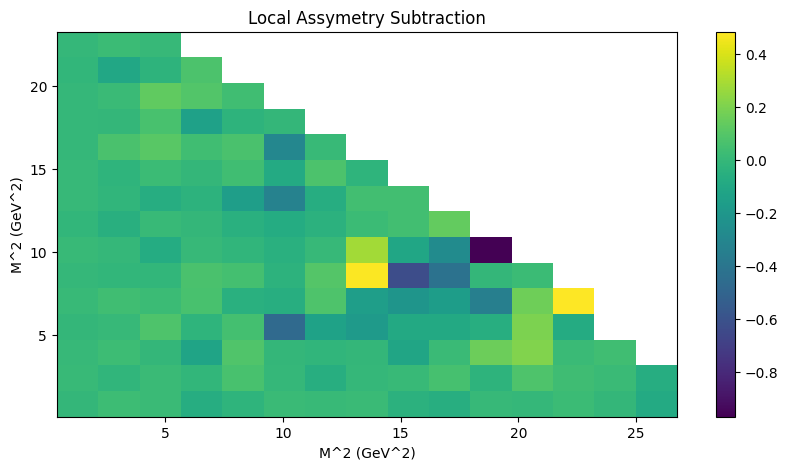

In [70]:
fig = plt.figure(figsize=(10, 5))
#subtract the weights of cleaned_positive_dalitz from cleaned_negative_dalitz
xcentres = []
ycentres = []
for a,b in zip(cleaned_positive_dalitz[1][0:-1],cleaned_positive_dalitz[1][1:]):
    for c,d in zip(cleaned_positive_dalitz[2][0:-1],cleaned_positive_dalitz[2][1:]):
        xcentres.append( (a+b)/2 )
        ycentres.append( (c+d)/2 )
    
w1 = (np.array(cleaned_positive_dalitz[0])).flatten()
w2 = (np.array(cleaned_negative_dalitz[0])).flatten()
wsub = np.subtract(w1,w2) # subtract bin content of two histograms
wsummed = np.add(w1,w2)
w_assymetry = np.divide(wsub, wsummed)

# produce the new histogram
cleaned_dalitz = plt.hist2d(xcentres,ycentres,weights=w_assymetry,
 bins = [cleaned_positive_dalitz[1],cleaned_positive_dalitz[2]],
            ) # recycle the binning from above 
plt.colorbar(cleaned_dalitz[3]) # let's add the colour scale for histo 3
plt.title('Local Assymetry Subtraction')
plt.xlabel('M^2 (GeV^2)')
plt.ylabel('M^2 (GeV^2)')

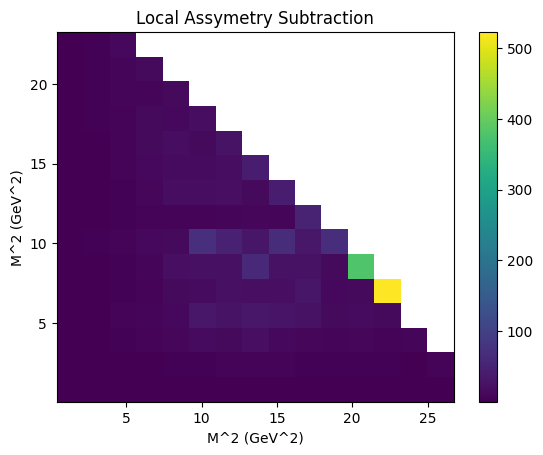

In [72]:
w_unc = np.sqrt( 1- np.square(w_assymetry)) / np.sqrt(wsummed)
dalitz_unc = plt.hist2d(xcentres, ycentres, weights=w_unc, bins = [cleaned_positive_dalitz[1],cleaned_positive_dalitz[2]],
            )

plt.title('Local Assymetry Subtraction')
plt.xlabel('M^2 (GeV^2)')
plt.ylabel('M^2 (GeV^2)')
plt.colorbar(dalitz_unc[3]) # let's add the colour scale for histo 3


# Variable Bin Width

Text(0, 0.5, 'M^2 (GeV^2)')

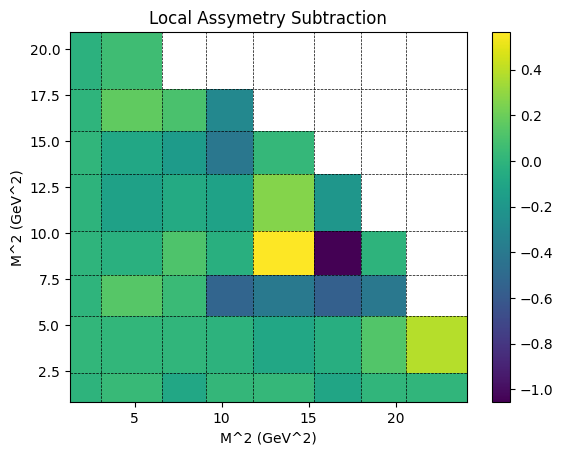

In [115]:
from scipy.stats import mstats
# find quantiles for the assymetry

num_data_points = len(w_assymetry)
size_per_bin = num_data_points / 9
bin_prob_array = []
for i in range(0, 9):
    bin_prob_array.append(i * size_per_bin/num_data_points)

quantiles_x = mstats.mquantiles(xcentres, prob=bin_prob_array)
quantiles_y = mstats.mquantiles(ycentres, prob=bin_prob_array)

# plot a 2D histogram of the assymetry using the quantiles as the bin edges
new_hist = plt.hist2d(xcentres, ycentres, weights=w_assymetry,
             bins = [quantiles_x, quantiles_y]);
plt.colorbar() # let's add the colour scale for histo 3

#plot vertical lines for the quantiles
for i in range(0, len(quantiles_x)):
    plt.axvline(x=quantiles_x[i], color='k', linestyle='--', linewidth=0.5)
    plt.axhline(y=quantiles_y[i], color='k', linestyle='--', linewidth=0.5)

plt.title('Local Assymetry Subtraction')
plt.xlabel('M^2 (GeV^2)')
plt.ylabel('M^2 (GeV^2)')


# JPsi Fitting

In [1]:
from sys import modules


from src.file_read_jpsi import read_file
plus_two_body = read_file(mode=4, interest="B+", MAX_EVENTS=10000, selection=True)

 Selecting B+ events
Input data varaiables: 
Magnet up and down data
['DecayTree;1']
Varialbes read



  1%|▏         | 132/10000 [00:00<00:24, 398.94it/s]

[1, 0, 1]
3145.002778186845
[1, 1, 0]
3087.7683660831813


  2%|▏         | 218/10000 [00:00<00:27, 359.80it/s]

[1, 0, 1]
3115.2839057068504
[1, 0, 1]
3104.3510454017232


  7%|▋         | 652/10000 [00:01<00:30, 305.87it/s]

[1, 1, 0]
3071.7259143444835
[1, 0, 1]
2797.751644626598


  7%|▋         | 741/10000 [00:02<00:25, 356.28it/s]

[1, 1, 0]
3097.1055019879745


  9%|▉         | 949/10000 [00:02<00:24, 372.44it/s]

[1, 1, 0]
3107.8292463464963


 13%|█▎        | 1257/10000 [00:03<00:22, 386.11it/s]

[1, 1, 0]
3696.4352643107973
[1, 0, 1]
3095.9188036405603
[1, 1, 0]
3108.3358734538683


 18%|█▊        | 1753/10000 [00:04<00:17, 463.79it/s]

[1, 0, 1]
3101.97141601673


 19%|█▊        | 1858/10000 [00:04<00:17, 478.75it/s]

[1, 1, 0]
3088.9453157179937
[1, 1, 0]
3095.511350448544
[1, 0, 1]
3126.25580300506


 22%|██▏       | 2184/10000 [00:05<00:12, 609.01it/s]

[1, 1, 0]
3108.773171628484
[1, 0, 1]
3092.6751431129496


 23%|██▎       | 2298/10000 [00:05<00:16, 467.47it/s]

[1, 0, 1]
3110.7010606505924
[1, 1, 0]
3835.7890015639205


 24%|██▍       | 2435/10000 [00:06<00:28, 265.77it/s]

[1, 0, 1]
3072.034333785985


 25%|██▌       | 2533/10000 [00:06<00:25, 289.15it/s]

[1, 0, 1]
3107.769765282852
[1, 1, 0]
3105.9701602849514


 29%|██▊       | 2862/10000 [00:07<00:17, 419.34it/s]

[1, 1, 0]
3679.890063585036
[1, 1, 0]
3098.473258619701
[1, 1, 0]
3098.020647927467
[1, 0, 1]
3071.3058075849303
[1, 1, 0]
3102.184568571272


 30%|██▉       | 2959/10000 [00:07<00:18, 383.99it/s]

[1, 0, 1]
3131.865908453144


 31%|███       | 3065/10000 [00:08<00:16, 429.79it/s]

[1, 0, 1]
3100.133649416225
[1, 0, 1]
3123.5064187790726


 32%|███▏      | 3177/10000 [00:08<00:13, 489.60it/s]

[1, 0, 1]
3075.607072657721
[1, 0, 1]
3105.9784264659656


 33%|███▎      | 3343/10000 [00:08<00:12, 519.75it/s]

[1, 0, 1]
3085.2109598782845
[1, 0, 1]
3111.6617989845713
[1, 0, 1]
3689.2700920752136


 35%|███▍      | 3454/10000 [00:08<00:13, 481.71it/s]

[1, 0, 1]
3129.8999448749855


 36%|███▌      | 3551/10000 [00:09<00:15, 422.08it/s]

[1, 0, 1]
3080.2051407778495
[1, 0, 1]
3096.751726458453


 37%|███▋      | 3658/10000 [00:09<00:13, 457.88it/s]

[1, 0, 1]
3700.620102374652
[1, 0, 1]
3101.27923750205
[1, 0, 1]
3113.3386057207817
[1, 1, 0]
3076.186658575549


 39%|███▉      | 3945/10000 [00:09<00:10, 589.21it/s]

[1, 1, 0]
3086.1106201180487
[1, 0, 1]
3693.6496182068818
[1, 1, 0]
3091.94810312121


 43%|████▎     | 4258/10000 [00:10<00:07, 731.69it/s]

[1, 1, 0]
3107.3047721811663


 46%|████▌     | 4576/10000 [00:10<00:06, 786.99it/s]

[1, 0, 1]
3105.28783945152
[1, 0, 1]
3103.8607938806317


 47%|████▋     | 4734/10000 [00:10<00:06, 770.93it/s]

[1, 1, 0]
3123.0821220971534


 50%|████▉     | 4959/10000 [00:11<00:07, 674.22it/s]

[1, 1, 0]
3712.920178814212


 53%|█████▎    | 5263/10000 [00:11<00:06, 732.40it/s]

[1, 1, 0]
3114.029420871705
[1, 0, 1]
3091.9451208907276
[1, 0, 1]
3099.055052980094
[1, 1, 0]
3093.322609906546


 54%|█████▍    | 5410/10000 [00:11<00:06, 687.82it/s]

[1, 1, 0]
3107.797826130643


 58%|█████▊    | 5849/10000 [00:12<00:05, 732.78it/s]

[1, 0, 1]
3107.0049338139675
[1, 1, 0]
3090.1527245219386


 62%|██████▏   | 6235/10000 [00:12<00:05, 747.07it/s]

[1, 1, 0]
3111.9550661917174
[1, 1, 0]
3105.2484942203687


 65%|██████▌   | 6529/10000 [00:13<00:05, 684.45it/s]

[0, 1, 1]
1288.4330707038134
[1, 0, 1]
3077.146090307117


 67%|██████▋   | 6748/10000 [00:13<00:04, 703.66it/s]

[1, 0, 1]
3079.134379680054
[1, 0, 1]
3077.7739451771117
[1, 1, 0]
3000.3935384856654
[1, 1, 0]
3079.4356437338865
[1, 1, 0]
3088.678911549658
[1, 1, 0]
3108.4987802102733


 69%|██████▉   | 6890/10000 [00:13<00:04, 692.50it/s]

[1, 1, 0]
3099.570251600376


 70%|███████   | 7032/10000 [00:14<00:04, 680.54it/s]

[1, 1, 0]
3106.3857455784796
[1, 1, 0]
3073.6927100556113
[1, 1, 0]
3093.247479998953
[1, 0, 1]
3073.901320456424
[1, 0, 1]
3697.3539102753016


 72%|███████▏  | 7249/10000 [00:14<00:03, 698.10it/s]

[1, 1, 0]
3113.126353637563
[1, 1, 0]
3116.5593035627326
[1, 1, 0]
3074.72224644265


 74%|███████▍  | 7388/10000 [00:14<00:03, 675.04it/s]

[1, 1, 0]
3105.9463088650177
[1, 0, 1]
3125.5890251068045
[1, 1, 0]
3098.858577428709


 79%|███████▉  | 7875/10000 [00:15<00:02, 810.67it/s]

[1, 1, 0]
3108.028212181529
[1, 0, 1]
3088.3741937612267
[1, 0, 1]
3093.8541918607334
[1, 1, 0]
3069.600902695954
[1, 1, 0]
3103.480229463694


 80%|████████  | 8038/10000 [00:15<00:02, 775.49it/s]

[1, 0, 1]
3112.190694630164
[1, 0, 1]
3098.1777638391677


 82%|████████▏ | 8217/10000 [00:15<00:02, 834.85it/s]

[1, 1, 0]
3018.2014784177895


 85%|████████▍ | 8470/10000 [00:15<00:01, 825.71it/s]

[1, 0, 1]
3103.7683744585293


 86%|████████▋ | 8639/10000 [00:16<00:01, 784.49it/s]

[1, 0, 1]
3094.0726820902746
[1, 0, 1]
3079.1210093861264
[1, 1, 0]
3105.843492754741
[1, 0, 1]
3088.5071047885986


 90%|████████▉ | 8969/10000 [00:16<00:01, 930.69it/s]

[1, 1, 0]
3093.7663727430727
[1, 1, 0]
3080.210220778533


 93%|█████████▎| 9251/10000 [00:16<00:00, 1169.42it/s]

[1, 1, 0]
3092.384125854005
[1, 1, 0]
4198.393166979684
[1, 1, 0]
3090.2769860174176
[1, 1, 0]
3089.5214883335157
[1, 0, 1]
3102.4543863845706


 96%|█████████▌| 9577/10000 [00:17<00:00, 934.97it/s] 

[1, 0, 1]
3117.3516981740086
[1, 1, 0]
3101.1596343999354
[1, 0, 1]
3129.7586921219554


100%|██████████| 10000/10000 [00:17<00:00, 575.29it/s]


[1, 0, 1]
3070.7210237789227
[1, 0, 1]
3112.263831139631
[1, 1, 0]
3117.984094372267
[1, 0, 1]
3094.7617593550012
[1, 0, 1]
3117.4411285831416
[1, 1, 0]
3116.7168722576102


  0%|          | 0/10000 [00:00<?, ?it/s]


: 

 Selecting B+ events
Input data varaiables: 
Magnet up and down data
['DecayTree;1']
Varialbes read



100%|██████████| 10/10 [00:00<00:00, 694.06it/s]


in selection
[[0.8887550830841064, 0.038615524768829346], [0.09576037526130676, 0.3075411021709442], [0.13884514570236206, 0.19300395250320435]]
selection rule failed
in selection
assign kaon iterator failed
in selection
in selection
in selection
in selection
in selection
in selection
in selection
assign kaon iterator failed
in selection
assign kaon iterator failed


  0%|          | 0/10 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [4]:
#plot the plus_two body in a histogram 
plt.hist(plus_two_body, bins=10, label='B+')

NameError: name 'plt' is not defined

In [ ]:
plus_two_body